In [6]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.cm import ScalarMappable
from utils.helper_functions import find_files_in_dir
from matplotlib.colors import LinearSegmentedColormap, Normalize
from utils.helper_functions import sleep_metrics, calculate_cbtmin

In [7]:
figsize = (8, 4)
title_fontsize = 20
tick_label_fontsize = 14
legend_fontsize = 14
axis_label_fontsize = 16
text_fontsize = 18

# Figure 1

In [19]:
hours_per_day = 24
colors_cmap = ["black", "gold"]
position = [0, 1]

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", list(zip(position, colors_cmap)))

def next_multiple_of_ten(n):
    return ((n + 9) // 10) * 10

def plot_actogram_double_plotted(light, dt, simulation_days, ebook_first=True,
                                 vmax=None, save_name=None, show_fig=False):
    light = np.array(light)

    # DLMO collection time on 6 and day 12, set those values to NaN
    dlmo_collection = np.ones_like(light)
    dlmo_collection_masks = [
        (int(len(light) * 0.75 / 14.0), int(len(light) * 0.9167 / 14.0)),
        (int(len(light) * 1.25 / 14.0), int(len(light) * 1.4167 / 14.0)),
        (int(len(light) * 6.75 / 14.0), int(len(light) * 6.9167 / 14.0)),
        (int(len(light) * 7.25 / 14.0), int(len(light) * 7.4167 / 14.0)),
        (int(len(light) * 12.75 / 14.0), int(len(light) * 12.9167 / 14.0)),
        (int(len(light) * 13.25 / 14.0), int(len(light) * 13.4167 / 14.0)),

    ]
    for dlmo_collection_mask in dlmo_collection_masks:
        dlmo_collection[dlmo_collection_mask[0]:dlmo_collection_mask[1]] = np.nan
    dlmo_collection = dlmo_collection.reshape(
        (simulation_days, int(hours_per_day / dt)))

    custom_cmap.set_bad(color='lightcoral')  # Set color for NaNs

    if vmax is None:
        vmax = next_multiple_of_ten(np.max(light))
    norm = colors.Normalize(vmin=0,
                    vmax=vmax)
    

    amplitude_delta = light
    amplitude_delta = amplitude_delta.reshape(-1, 1)

    scaled_data = amplitude_delta.reshape(
        (simulation_days, int(hours_per_day / dt))) * dlmo_collection

    double_plotted_data = np.zeros(
        (simulation_days, int(hours_per_day / dt * 2)))

    # Last day does not have a "next day" to concatenate
    for day in range(simulation_days - 1):
        double_plotted_data[day] = np.concatenate(
            (scaled_data[day], scaled_data[day + 1]))
    double_plotted_data[-1] = np.concatenate(
        (scaled_data[-1], np.zeros_like(scaled_data[-1])))

    fig, ax = plt.subplots(figsize=figsize)

    # norm.autoscale_None([np.nan])  # Auto-scale to include NaN
    # Log norm including nan
    norm = colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=0, vmax=vmax)
    norm.autoscale_None([np.nan])  # Auto-scale to include NaN


    cax = ax.imshow(double_plotted_data, aspect='auto',
                    cmap=custom_cmap, norm=norm , interpolation='none',
                    rasterized=True)

    cbar = fig.colorbar(cax, ax=ax, pad=0.01)
    cbar.ax.tick_params(labelsize=tick_label_fontsize)
    cbar.ax.get_yaxis().labelpad = 25
    cbar.ax.set_ylabel('Light level (lux)', rotation=270, fontsize=axis_label_fontsize)

    # Adjust ticks for 48-hour x-axis
    dt_plot = 4
    x_ticks = np.arange(0, hours_per_day / dt * 2, dt_plot / dt)

    x_tick_labels = [str(int(x % hours_per_day))
                     for x in np.arange(0, hours_per_day * 2, dt_plot)]
    ax.set_xlabel('Local time', fontsize=axis_label_fontsize)
    ax.set_ylabel('Day', fontsize=axis_label_fontsize)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, fontsize=tick_label_fontsize)

    day_step = 2
    ax.set_yticks(np.arange(0, simulation_days, day_step))
    ax.set_yticklabels(np.arange(1, simulation_days + 1, day_step),
                       fontsize=tick_label_fontsize)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Cbar ticks
    cbar_label_numbers = [0, 1, 10, 100, 500]
    cbar.set_ticks(cbar_label_numbers)
    cbar_labels = [f"{x}" for x in cbar_label_numbers]
    cbar.set_ticklabels(cbar_labels)

    # Cbar title fontsize and location
    cbar.ax.yaxis.label.set_fontsize(axis_label_fontsize)
    cbar.ax.yaxis.set_label_coords(5.5, 0.5)

    # Ebook-book text
    kwargs_book = {'fontsize': text_fontsize, 'rotation': 90, 'alpha': 0.75, 'color': 'white'}
    kwargs_ebook = {'fontsize': text_fontsize, 'rotation': 90, 'alpha': 0.75, 'color': 'white'}
    if ebook_first:
        first_text_location_1 = (19.0 / dt, 4.4)
        first_text_location_2 = (43.0 / dt, 3.4)
        second_text_location_1 = (19.0 / dt, 10.0)
        second_text_location_2 = (43.0 / dt, 9.0)
        ax.text(*first_text_location_1, 'eBook', **kwargs_ebook)
        ax.text(*first_text_location_2, 'eBook', **kwargs_ebook)
        ax.text(*second_text_location_1, 'Book', **kwargs_book)
        ax.text(*second_text_location_2, 'Book', **kwargs_book)
    else:
        first_text_location_1 = (19.0 / dt, 4.0)
        first_text_location_2 = (43.0 / dt, 3.0)
        second_text_location_1 = (19.0 / dt, 10.4)
        second_text_location_2 = (43.0 / dt, 9.4)
        ax.text(*first_text_location_1, 'Book', **kwargs_book)
        ax.text(*first_text_location_2, 'Book', **kwargs_book)
        ax.text(*second_text_location_1, 'eBook', **kwargs_ebook)
        ax.text(*second_text_location_2, 'eBook', **kwargs_ebook)

    # Make last day white as a white box
    rect_x = 24.0 / dt
    rect_y = 12.5
    rect_width = 24 / dt
    rect_height = 1.0
    rect = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, 
                             linewidth=0, edgecolor='black', facecolor='white')
    ax.add_patch(rect)

    # DLMO collection time text
    dlmo_text_locations = [
        (19.0 / dt, 0.25), (31.0 / dt, 0.25), (7.0 / dt, 1.25), 
        (43.0 / dt, 5.25), (19.0 / dt, 6.25), (31.0 / dt, 6.25), (7.0 / dt, 7.25), 
        (43.0 / dt, 11.25), (19.0 / dt, 12.25), (31.0 / dt, 12.25), (7.0 / dt, 13.25), 

    ]
    dlmo_text_locations = np.array(dlmo_text_locations) * np.array([1, 1.01])
    for dlmo_text_location in dlmo_text_locations:
        ax.text(*dlmo_text_location, 'CP', fontsize=text_fontsize * 0.75, alpha=0.5)
    
    plt.tight_layout()
    if save_name:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    if show_fig:
        plt.show()
    plt.close()

## Actograms

In [20]:
light_schedules_data_path = '../data/light_schedules/'

In [22]:
dt = 0.005
simulation_days = 14
baseline_lux_options = [90, 500]
ebook_order_options = ['ebook_first', 'ebook_second']

time = np.load(f'{light_schedules_data_path}/time.npy')
light_options = []

for baseline_lux in baseline_lux_options:
    for ebook_order in ebook_order_options:
        light_schedule = np.load(f'{light_schedules_data_path}/chang14_light_indoor_lux_{baseline_lux}_{ebook_order}_light.npy')
        light_options.append(light_schedule)

In [23]:
ebook_first_order = [
    True, False, True, False
]
names = []
for baseline_lux in baseline_lux_options:
    for ebook_order in ebook_order_options:
        names.append(f'{ebook_order}_{baseline_lux}_indoor_light')

for light, ebook_first in zip(light_options, ebook_first_order):
    save_name = f'../figures/fig_1_{names.pop(0)}.png'
    plot_actogram_double_plotted(light, dt, simulation_days,
                                 ebook_first=ebook_first, vmax=500,
                                 save_name=save_name, show_fig=False)

## Sleep onset evolution

In [24]:
simulation_features = pd.read_csv("../data/simulations/chang14_sleep_parameters/chang14_sleep_parameters_features.csv", index_col=0)

In [28]:
show_fig = False
baseline_lux_options = [90, 500]
marker_options = ['o', 'o']
color_options = ['tab:blue', 'tab:green']
labels = ['90 lux baseline', '500 lux baseline']
offset = [0.0, 0.0]
CP_color = 'lightcoral'

for idx, baseline_lux in enumerate(baseline_lux_options):

    fig, axs = plt.subplots(2, 1, figsize=(figsize[0], 2 * figsize[1]), sharey=True, sharex=True)

    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'ebook_first') & \
                                      (simulation_features['baseline_lux'] == baseline_lux)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'ebook_second') & \
                                       (simulation_features['baseline_lux'] == baseline_lux)]

    ebook_first_sleep_onset = ebook_first.groupby('day')['sleep_onset'].mean() + offset[idx]
    ebook_second_sleep_onset = ebook_second.groupby('day')['sleep_onset'].mean() + offset[idx]

    days = np.arange(1, 14)

    axs[0].plot(days, ebook_first_sleep_onset,
                marker=marker, color=color_options[idx],
                label=labels[idx], zorder=2)

    axs[1].plot(days, ebook_second_sleep_onset,
                marker=marker, color=color_options[idx],
                label=labels[idx], zorder=2)

    # Add points for individual data
    dataset_0 = []
    dataset_1 = []
    for day in ebook_first['day'].unique():
        sleep_onset_values_first = ebook_first[ebook_first['day'] == day]['sleep_onset']
        sleep_onset_values_second = ebook_second[ebook_second['day'] == day]['sleep_onset']
        dataset_0.append(sleep_onset_values_first)
        dataset_1.append(sleep_onset_values_second)

    v0 = axs[0].violinplot(dataset_0, positions=days, widths=0.75, showmeans=False, 
                    showextrema=False, showmedians=False)
    v1 = axs[1].violinplot(dataset_1, positions=days, widths=0.75, showmeans=False, 
                    showextrema=False, showmedians=False)

    for pc in v0['bodies']:
        pc.set_facecolor(color_options[idx])
        pc.set_edgecolor('black')
        pc.set_alpha(0.5)

    for pc in v1['bodies']:
        pc.set_facecolor(color_options[idx])
        pc.set_edgecolor('black')
        pc.set_alpha(0.5)

    # Set days 7 and 13 as CP color
    for idx, pc in enumerate(v0['bodies']):
        if idx == 6 or idx == 12:
            pc.set_facecolor(CP_color)

    for idx, pc in enumerate(v1['bodies']):
        if idx == 6 or idx == 12:
            pc.set_facecolor(CP_color)

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])
    axs[0].set_yticks([21.5, 22, 22.5, 23, 23.5, 24])
    axs[0].set_yticklabels(['9:30 PM', '10:00 PM', '10:30 PM', '11:00 PM', '11:30 PM', '12:00 AM'],
                           fontsize=tick_label_fontsize)
    axs[1].set_yticklabels(['9:30 PM', '10:00 PM', '10:30 PM', '11:00 PM', '11:30 PM', '12:00 AM'],
                           fontsize=tick_label_fontsize)
    axs[1].tick_params(axis='x', labelsize=tick_label_fontsize)
    axs[0].set_ylim(21.5, 24)

    axs[0].set_ylabel('Sleep onset', fontsize=axis_label_fontsize)
    axs[1].set_ylabel('Sleep onset', fontsize=axis_label_fontsize)
    axs[1].set_xlabel('Day', fontsize=axis_label_fontsize)

    axs[0].axvspan(2, 6, color='gold', alpha=0.2, label='eBook', zorder=0)
    axs[0].axvspan(8, 12, color='gray', alpha=0.1, label='Book', zorder=0)
    axs[1].axvspan(2, 6, color='gray', alpha=0.1, zorder=0)
    axs[1].axvspan(8, 12, color='gold', alpha=0.2, zorder=0)

    fig.subplots_adjust(wspace=0.05)

    # add text to each condition
    axs[0].text(4, 21.7, 'eBook', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
    axs[0].text(10, 21.7, 'Book', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
    axs[1].text(4, 21.7, 'Book', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
    axs[1].text(10, 21.7, 'eBook', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)

    plt.tight_layout()
    plt.savefig(f'../figures/fig_1_sleep_onset_evolution_{baseline_lux}_indoor_light.png', bbox_inches='tight', dpi=300)
    if show_fig:
        plt.show()
    plt.close()

## Sleep latency

In [32]:
show_fig = False
baseline_lux_options  = [90, 500]
scheduled_bedtime = 22.0
marker_colors = ['tab:blue', 'tab:red']

df = pd.DataFrame()

for idx, baseline_lux in enumerate(baseline_lux_options):
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == 'ebook_first') |  \
                                      (simulation_features['simulation_condition'] == 'ebook_second') ) & \
                                     (simulation_features['baseline_lux'] == baseline_lux)

    book_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_latency_minutes']

    ebook_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_latency_minutes']

    condition_name = f'{baseline_lux} lux baseline'
    sub_df = pd.DataFrame({
        'sleep_latency': np.concatenate([book_sleep_latency, ebook_sleep_latency]),
        'condition': ['Book'] * len(book_sleep_latency) + ['eBook'] * len(ebook_sleep_latency),
    }, index=np.arange(len(book_sleep_latency) + len(ebook_sleep_latency)))


    fig, ax = plt.subplots(figsize=figsize)
    palette = {'Book': 'gray', 'eBook': 'gold'}

    plotting_parameters = {
        'data': sub_df,
        'x': 'condition',
        'y': 'sleep_latency',
        'cut': 0,
        'inner': None,
    }
    violin_colors = ['gray', 'gold']
    violin_tops = []

    sns.violinplot(**plotting_parameters, ax=ax)
    for violin  in ax.collections[::]:
        violin.set_alpha(0.5)
        violin.set_facecolor(violin_colors.pop(0))
        # top of the violin
        top = violin.get_paths()[0].vertices[:, 1].max()
        violin_tops.append(top)


    # Add point in the mean
    mean_values = sub_df.groupby('condition').mean()
    ax.scatter([0, 1], mean_values['sleep_latency'], color='black', zorder=1000, 
               alpha=0.7)

    # Calculate individual differences
    individual_differences = (ebook_sleep_latency - book_sleep_latency).values
    diff = np.mean(individual_differences)
    diff_std = np.std(individual_differences)

    # Annotation of difference between conditions
    line_top = max(violin_tops) + 10
    ax.plot([0, 1], [line_top, line_top], color='gray', linewidth=2)
    ax.plot([0, 0], [violin_tops[0] + 2.5, line_top], color='gray', linewidth=2)
    ax.plot([1, 1], [violin_tops[1] + 2.5, line_top], color='gray', linewidth=2)
    ax.annotate(fr'$\delta$ = ({diff:.1f} $\pm$ {diff_std:.1f}) min', xy=(0.5, line_top), xytext=(0.5, line_top - 7),
                fontsize=12, color='black', ha='center', va='center', zorder=1000)

    # Change x tick labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Book', 'eBook'], fontsize=tick_label_fontsize)
    ax.tick_params(axis='y', labelsize=tick_label_fontsize)

    ax.set_ylim(-5, 100)

    ax.set_ylabel('Sleep latency (minutes)', fontsize=axis_label_fontsize)
    ax.set_xlabel('')

    plt.savefig(f'../figures/fig_1_sleep_latency_{baseline_lux}_indoor_light.png', bbox_inches='tight', dpi=300)

    if show_fig:
        plt.show()
    plt.close()

# Figure 2

## Circadian state

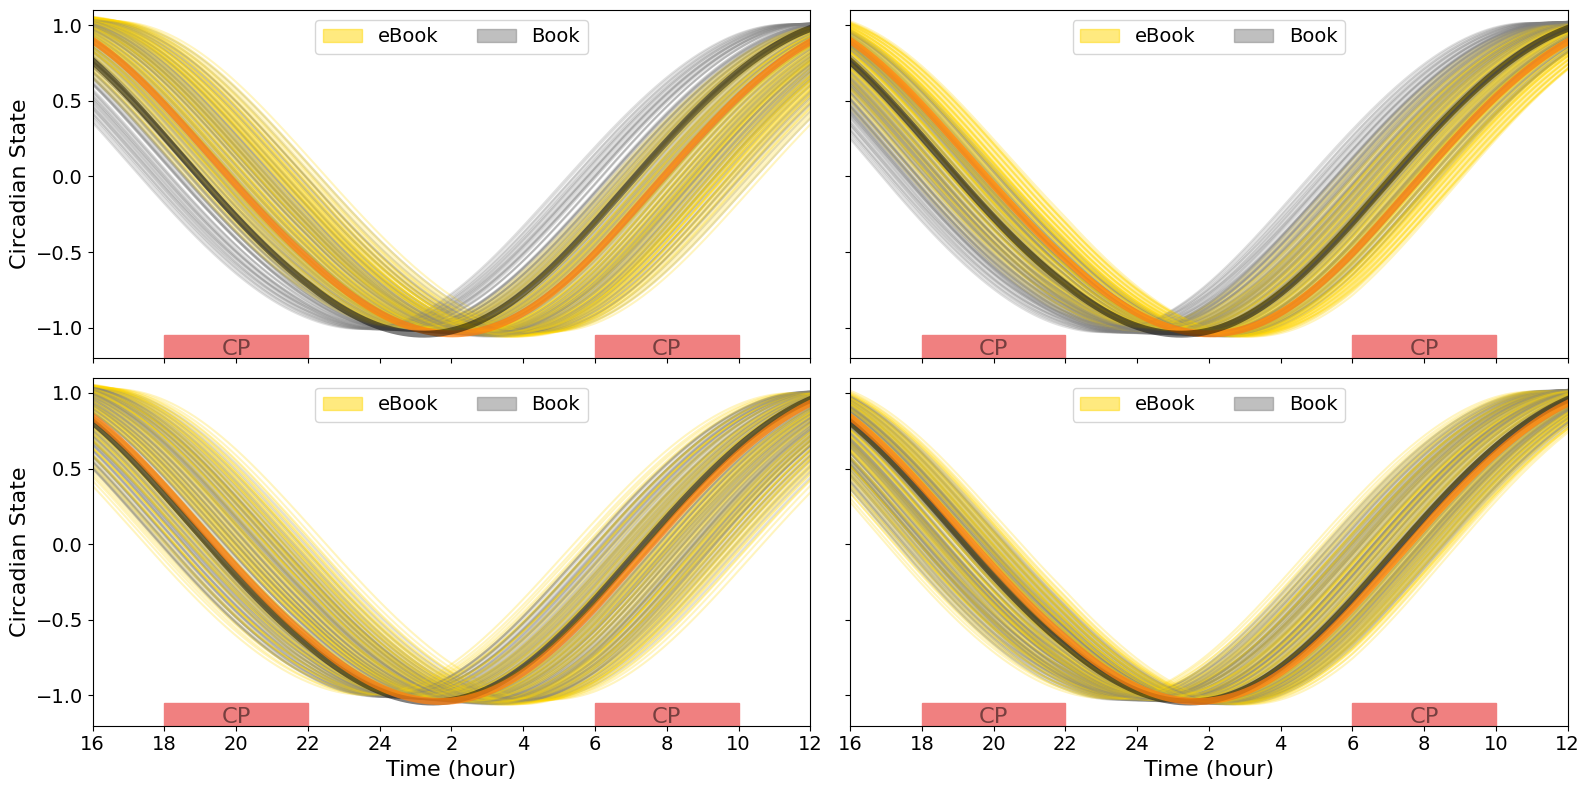

In [46]:
show_fig = False
baseline_lux_options = [90, 500]
ebook_order_options = ['ebook_first', 'ebook_second']
data_path = '../data/simulations/chang14_circadian_parameters/'
time = np.load(f'../data/light_schedules/time.npy') / 24.0 # convert to days

first_week_mask_start = 6.0 + 16.0 / 24.0 # 16 hrs on day 6
first_week_mask_end = 7.0 + 12.0 / 24.0 # 12 hrs on day 7
second_week_mask_start = 12.0 + 16.0 / 24.0 # 16 hrs on day 12
second_week_mask_end = 13.0 + 12.0 / 24.0 # 12 hrs on day 13

fig, axs = plt.subplots(2, 2, figsize=(figsize[0] * 2, figsize[1] * 2), sharex=True, sharey=True)

for idx, ebook_order in enumerate(ebook_order_options):
    for jdx, baseline_lux in enumerate(baseline_lux_options):
        pattern = re.compile(
            rf"baseline_lux_{baseline_lux}_{ebook_order}_simulation_(\d+).npz"
        )
        files = find_files_in_dir(data_path, pattern)
        for filename in files:
            simulation_idx = int(re.search(pattern, filename).group(1))
            data = np.load(filename, allow_pickle=True)
            states = data["trajectory_states"]
            circadian_state = states[:, 0]

            first_week_mask = (time >= first_week_mask_start) & (time <= first_week_mask_end)
            second_week_mask = (time >= second_week_mask_start) & (time <= second_week_mask_end)

            if ebook_order == 'ebook_first':
                first_condition = 'eBook'
                second_condition = 'Book'
                color_values = ['gold', 'gray']
            else:
                first_condition = 'Book'
                second_condition = 'eBook'
                color_values = ['gray', 'gold']

            axs[idx, jdx].plot((time[first_week_mask] - first_week_mask_end + 1) * 24, 
                              circadian_state[first_week_mask],
                              color=color_values[0], alpha=0.25,
                              label=first_condition, zorder=0)

            axs[idx, jdx].plot((time[second_week_mask] - second_week_mask_end + 1) * 24,
                              circadian_state[second_week_mask],
                              color=color_values[1], alpha=0.25,
                              label=second_condition, zorder=0)

# Add result with reference parameters
reference_data_path = '../data/simulations/reference_parameters'
for idx, ebook_order in enumerate(['ebook_first', 'ebook_second']):
    for jdx, baseline_condition in enumerate(['', 'high_']):
        data = np.load(f"{reference_data_path}/chang14_light_indoor_lux_{baseline_lux}_{ebook_order}_with_forced_wakeup_simulation.npz", 
                       allow_pickle=True)
        # Load reference simulation data
        trajectory_states = data["trajectory_states"]
        circadian_state = trajectory_states[:, 0]

        # time mask
        first_week_mask = (time >= first_week_mask_start) & (time <= first_week_mask_end)
        second_week_mask = (time >= second_week_mask_start) & (time <= second_week_mask_end)

        if ebook_order == 'ebook_first':
            first_condition = 'eBook'
            second_condition = 'Book'
            color_values = ['tab:orange', 'black']
            alpha_values = [0.75, 0.5]
        else:
            first_condition = 'Book'
            second_condition = 'eBook'
            color_values = ['black', 'tab:orange']
            alpha_values = [0.5, 0.75]

        axs[idx, jdx].plot((time[first_week_mask] - first_week_mask_end + 1) * 24, 
                    circadian_state[first_week_mask], 
                    color=color_values[0], alpha=alpha_values[0], label='Reference parameters eBook',
                    linewidth=5, zorder=1)
        
        axs[idx, jdx].plot((time[second_week_mask] - second_week_mask_end + 1) * 24,
                    circadian_state[second_week_mask], 
                    color=color_values[1], alpha=alpha_values[1], label='Reference parameters Book',
                    linewidth=5, zorder=1)

axs[0, 0].set_ylabel("Circadian State", fontsize=axis_label_fontsize)
axs[1, 0].set_ylabel("Circadian State", fontsize=axis_label_fontsize)
axs[1, 0].set_xlabel("Time (hour)", fontsize=axis_label_fontsize)
axs[1, 1].set_xlabel("Time (hour)", fontsize=axis_label_fontsize)

# Constant procedures as rectangles
for idx in range(2):
    for jdx in range(2):
        rect_width = 4
        rect_height = 0.15
        rect1 = patches.Rectangle((6, -1.2), rect_width, rect_height, linewidth=1, edgecolor='lightcoral', facecolor='lightcoral')
        rect2 = patches.Rectangle((18, -1.2), rect_width, rect_height, linewidth=1, edgecolor='lightcoral', facecolor='lightcoral')
        axs[idx, jdx].add_patch(rect1)
        axs[idx, jdx].add_patch(rect2)
        text_location1 = (6 + rect_width / 2, -1.215 + rect_height / 2)
        text_location2 = (18 + rect_width / 2, -1.215 + rect_height / 2)
        axs[idx, jdx].text(*text_location1, 'CP', fontsize=text_fontsize * 0.9, ha='center', va='center', alpha=0.5)
        axs[idx, jdx].text(*text_location2, 'CP', fontsize=text_fontsize * 0.9, ha='center', va='center', alpha=0.5)

# Create legend with patches
legend_elements = [patches.Patch(facecolor='gold', edgecolor='gold', label='eBook', alpha=0.5),
                   patches.Patch(facecolor='gray', edgecolor='gray', label='Book', alpha=0.5)]
axs[0, 1].legend(handles=legend_elements, loc='best', fontsize=legend_fontsize, ncols=2)
axs[0, 0].legend(handles=legend_elements, loc='best', fontsize=legend_fontsize, ncols=2)
axs[1, 0].legend(handles=legend_elements, loc='best', fontsize=legend_fontsize, ncols=2)
axs[1, 1].legend(handles=legend_elements, loc='best', fontsize=legend_fontsize, ncols=2)


axs[0, 0].set_xticks(np.linspace(4, 24, 11))
axs[0, 0].set_xticklabels([
    '16', '18', '20', '22', '24', '2', '4', '6', '8', '10', '12'
], fontsize=tick_label_fontsize)
axs[0, 0].set_xlim([4, 24])
axs[0, 0].set_ylim([-1.2, 1.1])

axs[0, 0].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
axs[1, 0].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
axs[1, 1].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

plt.tight_layout()
plt.savefig(f"../figures/fig_2_circadian_states.png", bbox_inches='tight', dpi=300)

if show_fig:
    plt.show()

## Phase shift

In [72]:
figsize_scaling = 0.85
selected_parameters = pd.read_csv(f'../data/simulations/circadian_parameter_exploration/circadian_parameter_exploration_results.csv', index_col=0)
simulation_features = pd.read_csv("../data/simulations/chang14_circadian_parameters/chang14_circadian_parameters_features.csv", index_col=0)

In [80]:
def get_shift_data(simulation_features, baseline_lux, ebook_order):
    book_day = 12 if ebook_order == 'ebook_first' else 6
    ebook_day = 6 if ebook_order == 'ebook_first' else 12
    book_cbtmin = simulation_features[(simulation_features['day'] == book_day) & (simulation_features['daily_condition'] == 'Book') &
                                        (simulation_features['simulation_condition'] == f'{ebook_order}') &
                                        (simulation_features['baseline_lux'] == baseline_lux)]
    ebook_cbtmin = simulation_features[(simulation_features['day'] == ebook_day) & (simulation_features['daily_condition'] == 'eBook') &
                                        (simulation_features['simulation_condition'] == f'{ebook_order}') &
                                        (simulation_features['baseline_lux'] == baseline_lux)]

    shift = pd.DataFrame()
    shift['diff'] = ebook_cbtmin['cbtmin'] - book_cbtmin['cbtmin']
    shift['simulation_condition'] = ebook_cbtmin['simulation_condition']
    shift['baseline_lux'] = baseline_lux

    shift['p'] = selected_parameters['p'].values
    shift['k'] = selected_parameters['k'].values
    shift['tauc'] = selected_parameters['tauc'].values

    return shift

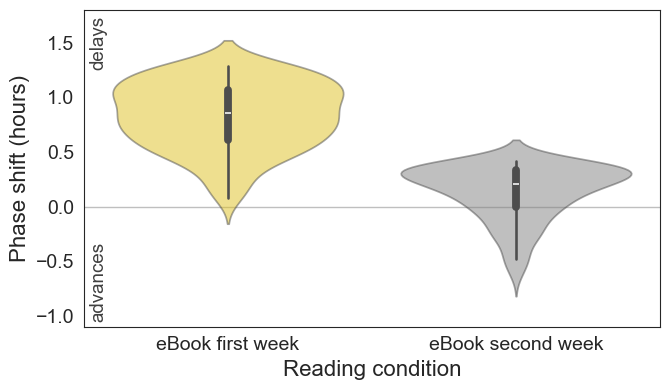

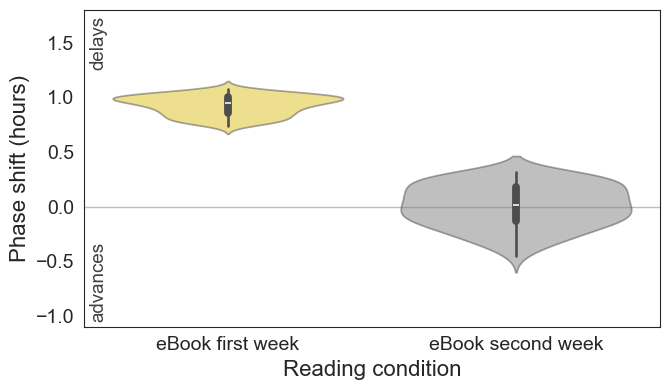

In [ ]:
show_fig = False
baseline_lux_options = [90, 500]

for baseline_lux in baseline_lux_options:
    shift_first = get_shift_data(simulation_features, baseline_lux, 'ebook_first')
    shift_second = get_shift_data(simulation_features, baseline_lux, 'ebook_second')
    df = pd.concat([shift_first, shift_second])

    sns.set_style('white')

    palette = {
        'ebook_first': 'gold',
        'ebook_second': 'gray'
    }

    fig, ax = plt.subplots(1, 1, figsize=(figsize_scaling * figsize[0], figsize[1]), sharey=True)
    sns.violinplot(x='simulation_condition', y='diff', hue='simulation_condition', data=df, ax=ax, palette=palette,)

    for violin  in ax.collections[::]:
        violin.set_alpha(0.5)

    ax.set_xticks(range(len(df['simulation_condition'].unique())))
    ax.set_xticklabels(['eBook first week', 'eBook second week'], fontsize=tick_label_fontsize)

    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    ax.set_ylabel('Phase shift (hours)', fontsize=axis_label_fontsize)
    ax.set_xlabel(r'Reading condition', fontsize=axis_label_fontsize)

    # Advance delay text, left side
    ax.text(-0.45, 1.5, 'delays', fontsize=0.75*text_fontsize, ha='center', va='center', color='black',
            rotation=90, alpha=0.75)

    ax.text(-0.45, -0.69, 'advances', fontsize=0.75*text_fontsize, ha='center', va='center', color='black',
            rotation=90, alpha=0.75)

    ax.set_ylim(-1.1, 1.8)

    ax.axhline(0, color='black', linewidth=1, linestyle='-', zorder=0, alpha=0.25)

    plt.tight_layout()

    plt.savefig(f"../figures/fig_2_phase_shift_indoor_lux_{baseline_lux}.png", bbox_inches='tight', dpi=300)

    if show_fig:
        plt.show()

## Different initial conditions

In [23]:
figsize_scaling = 0.875
legend_fontsize_scaling = 0.875
baseline_lux_options = [90, 500]
lights_on_start_times = [5, 6, 7, 8, 9]
ebook_order_options = ['ebook_first', 'ebook_second']
simulation_features = pd.read_csv(f"../data/simulations/different_initial_conditions/chang14_different_initial_conditions_features.csv")

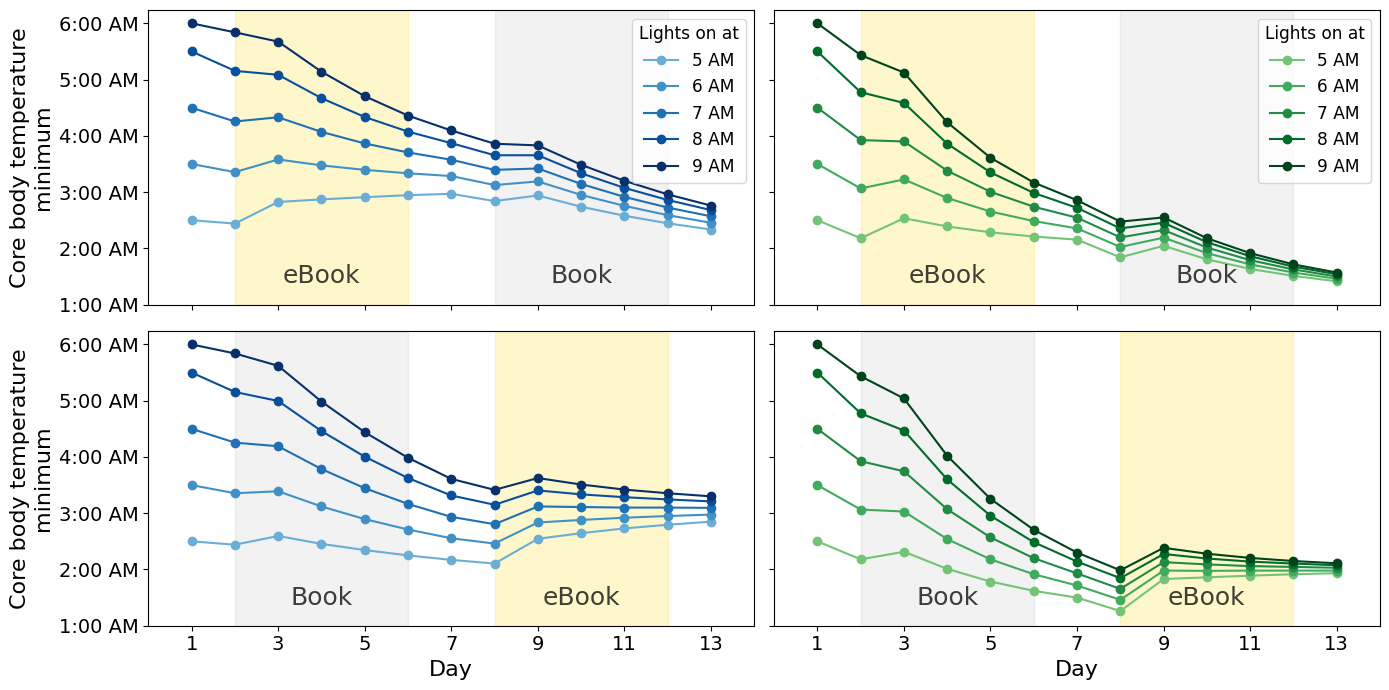

In [25]:
show_fig = True
colors_low = plt.get_cmap('Blues')(np.linspace(0.5, 1, len(lights_on_start_times)))
colors_high = plt.get_cmap('Greens')(np.linspace(0.5, 1, len(lights_on_start_times)))
color_options = [colors_low, colors_high]

fig, axs = plt.subplots(2, 2, figsize=(figsize_scaling * figsize[0] * 2, figsize_scaling * figsize[1] * 2), 
                        sharey=True, sharex=True)

for idx, lights_on in enumerate(lights_on_start_times):
    for jdx, ebook_order in enumerate(ebook_order_options):
        for kdx, baseline_lux in enumerate(baseline_lux_options):
            data_subset = simulation_features[(simulation_features['lights_on'] == lights_on) &
                                              (simulation_features['simulation_condition'] == ebook_order) &
                                              (simulation_features['baseline_lux'] == baseline_lux)]
            days = data_subset['day'].values
            cbtmin = data_subset['cbtmin'].values
            # order arrays
            order = np.argsort(days)
            days = days[order]
            cbtmin = cbtmin[order]
            axs[jdx, kdx].plot(days, cbtmin, marker='o', color=color_options[kdx][idx], label=f'{lights_on} AM',)
            axs[jdx, kdx].set_xlim(0, 14)

for i in range(2):
    axs[0, i].axvspan(2, 6, color='gold', alpha=0.2) # eBook
    axs[0, i].axvspan(8, 12, color='gray', alpha=0.1) # Book
    axs[1, i].axvspan(2, 6, color='gray', alpha=0.1)
    axs[1, i].axvspan(8, 12, color='gold', alpha=0.2)

axs[0, 0].set_xlim(0, 14)
axs[1, 1].set_xlim(0, 14)

axs[0, 0].legend(fontsize=legend_fontsize * legend_fontsize_scaling, 
                 title='Lights on at', 
                 title_fontsize=legend_fontsize * legend_fontsize_scaling)
axs[0, 1].legend(fontsize=legend_fontsize * legend_fontsize_scaling, 
                 title='Lights on at', 
                 title_fontsize=legend_fontsize * legend_fontsize_scaling)

axs[1, 0].set_xlabel('Day', fontsize=axis_label_fontsize)
axs[1, 1].set_xlabel('Day', fontsize=axis_label_fontsize)
axs[1, 0].set_xticks(days[::2])

axs[0, 0].set_yticks([1, 2, 3, 4, 5, 6])
axs[0, 0].set_yticklabels(['1:00 AM', '2:00 AM', '3:00 AM', '4:00 AM', '5:00 AM', '6:00 AM'],
                        fontsize=tick_label_fontsize)
axs[1, 0].set_yticks([1, 2, 3, 4, 5, 6])
axs[1, 0].set_yticklabels(['1:00 AM', '2:00 AM', '3:00 AM', '4:00 AM', '5:00 AM', '6:00 AM'],
                        fontsize=tick_label_fontsize)

axs[0, 0].set_ylabel('Core body temperature\nminimum', fontsize=axis_label_fontsize)
axs[1, 0].set_ylabel('Core body temperature\nminimum', fontsize=axis_label_fontsize)

axs[1, 0].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
axs[1, 1].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

for i in range(2):
    axs[0, i].text(4, 1.5, 'eBook', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
    axs[0, i].text(10, 1.5, 'Book', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
    axs[1, i].text(4, 1.5, 'Book', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
    axs[1, i].text(10, 1.5, 'eBook', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
plt.tight_layout()
plt.savefig(f"../figures/fig_2_cbtmin_evolution.png", bbox_inches='tight', dpi=300)
if show_fig:
    plt.show()

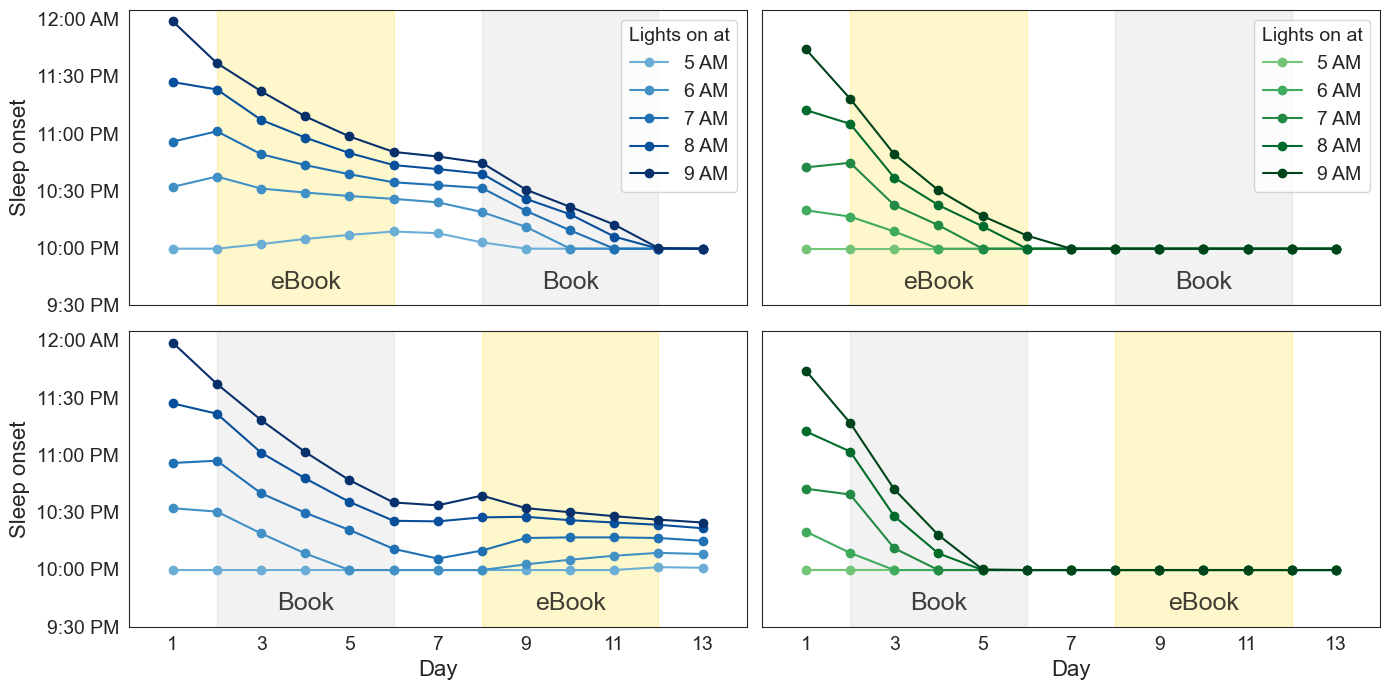

In [137]:
show_fig = False
colors_low = plt.get_cmap('Blues')(np.linspace(0.5, 1, len(lights_on_start_times)))
colors_high = plt.get_cmap('Greens')(np.linspace(0.5, 1, len(lights_on_start_times)))
color_options = [colors_low, colors_high]


fig, axs = plt.subplots(2, 2, figsize=(figsize_scaling * figsize[0] * 2, figsize_scaling * figsize[1] * 2), 
                        sharey=True, sharex=True)

for idx, lights_on in enumerate(lights_on_start_times):
    for jdx, ebook_order in enumerate(ebook_order_options):
        for kdx, baseline_lux in enumerate(baseline_lux_options):
            data_subset = simulation_features[(simulation_features['lights_on'] == lights_on) &
                                              (simulation_features['simulation_condition'] == ebook_order) &
                                              (simulation_features['baseline_lux'] == baseline_lux)]
            days = data_subset['day'].values
            sleep_onset = data_subset['sleep_onset'].values
            # order arrays
            order = np.argsort(days)
            days = days[order]
            sleep_onset = sleep_onset[order]
            axs[jdx, kdx].plot(days, sleep_onset, marker='o', color=color_options[kdx][idx], label=f'{lights_on} AM',)
            axs[jdx, kdx].set_xlim(0, 14)

for i in range(2):
    axs[0, i].axvspan(2, 6, color='gold', alpha=0.2) # eBook
    axs[0, i].axvspan(8, 12, color='gray', alpha=0.1) # Book
    axs[1, i].axvspan(2, 6, color='gray', alpha=0.1)
    axs[1, i].axvspan(8, 12, color='gold', alpha=0.2)

axs[0, 0].set_xlim(0, 14)
axs[1, 1].set_xlim(0, 14)

axs[0, 0].legend(fontsize=legend_fontsize, title='Lights on at', title_fontsize=legend_fontsize)
axs[0, 1].legend(fontsize=legend_fontsize, title='Lights on at', title_fontsize=legend_fontsize)

axs[1, 0].set_xlabel('Day', fontsize=axis_label_fontsize)
axs[1, 1].set_xlabel('Day', fontsize=axis_label_fontsize)
axs[1, 0].set_xticks(days[::2])

axs[0, 0].set_yticks([21.5, 22, 22.5, 23, 23.5, 24])
axs[0, 0].set_yticklabels(['9:30 PM', '10:00 PM', '10:30 PM', '11:00 PM', '11:30 PM', '12:00 AM'],
                        fontsize=tick_label_fontsize)
axs[1, 0].set_yticks([21.5, 22, 22.5, 23, 23.5, 24])
axs[1, 0].set_yticklabels(['9:30 PM', '10:00 PM', '10:30 PM', '11:00 PM', '11:30 PM', '12:00 AM'],
                        fontsize=tick_label_fontsize)

axs[0, 0].set_ylabel('Sleep onset', fontsize=axis_label_fontsize)
axs[1, 0].set_ylabel('Sleep onset', fontsize=axis_label_fontsize)

axs[1, 0].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
axs[1, 1].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

for i in range(2):
    axs[0, i].text(4, 21.7, 'eBook', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
    axs[0, i].text(10, 21.7, 'Book', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
    axs[1, i].text(4, 21.7, 'Book', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
    axs[1, i].text(10, 21.7, 'eBook', horizontalalignment='center', verticalalignment='center',
                fontsize=text_fontsize, color='black', alpha=0.75)
plt.tight_layout()
plt.savefig(f"../figures/fig_2_sleep_onset_evolution.png", bbox_inches='tight', dpi=300)
if show_fig:
    plt.show()

# Figure 3

In [34]:
hours_per_day = 24
colors_cmap = ["black", "gold"]
position = [0, 1]

custom_cmap = colors.LinearSegmentedColormap.from_list(
    "custom_cmap", list(zip(position, colors_cmap)))

In [35]:
def next_multiple_of_ten(n):
    return ((n + 9) // 10) * 10


def plot_actogram_double_plotted(light, sleep, dt, simulation_days,
                                 vmax=None, save_name=None, nancolor='lightgrey'):
    light = np.array(light)
    # Set sleep values to NaN in the light array for plotting purposes
    if sleep is not None:
        sleep = np.array(sleep)
        # Mask the light values during sleep
        light[sleep == 1] = np.nan  # Assuming sleep=1 indicates sleep period

    custom_cmap.set_bad(color=nancolor)  # Set color for NaNs

    if vmax is None:
        vmax = next_multiple_of_ten(np.nanmax(light))
    norm = colors.Normalize(vmin=0,
                    vmax=vmax)
    

    amplitude_delta = light
    amplitude_delta = amplitude_delta.reshape(-1, 1)

    scaled_data = amplitude_delta.reshape(
        (simulation_days, int(hours_per_day / dt))) # * dlmo_collection

    double_plotted_data = np.zeros(
        (simulation_days, int(hours_per_day / dt * 2)))

    # Last day does not have a "next day" to concatenate
    for day in range(simulation_days - 1):
        double_plotted_data[day] = np.concatenate(
            (scaled_data[day], scaled_data[day + 1]))
    double_plotted_data[-1] = np.concatenate(
        (scaled_data[-1], np.zeros_like(scaled_data[-1])))

    fig, ax = plt.subplots(figsize=figsize)

    # norm.autoscale_None([np.nan])  # Auto-scale to include NaN
    # Log norm including nan
    norm = colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=0, vmax=vmax)
    norm.autoscale_None([np.nan])  # Auto-scale to include NaN

    cax = ax.imshow(double_plotted_data, aspect='auto',
                    cmap=custom_cmap, norm=norm , interpolation='none',
                    rasterized=True)


    # Adjust ticks for 48-hour x-axis
    dt_plot = 4
    x_ticks = np.arange(0, hours_per_day / dt * 2, dt_plot / dt)

    x_tick_labels = [str(int(x % hours_per_day))
                     for x in np.arange(0, hours_per_day * 2, dt_plot)]
    ax.set_xlabel('Local time', fontsize=axis_label_fontsize)
    ax.set_ylabel('Day', fontsize=axis_label_fontsize)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, fontsize=tick_label_fontsize)

    day_step = 2
    ax.set_yticks(np.arange(0, simulation_days, day_step))
    ax.set_yticklabels(np.arange(1, simulation_days + 1, day_step),
                       fontsize=tick_label_fontsize)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Cbar ticks
    cbar = fig.colorbar(cax, ax=ax, pad=0.01)

    cbar_label_numbers = [0, 0.1, 1, 10, 100, 1000, 5000]
    cbar.set_ticks(cbar_label_numbers)
    cbar_labels = [f"{x}" for x in cbar_label_numbers]

    cbar.set_ticklabels(cbar_labels)
    cbar.ax.tick_params(labelsize=tick_label_fontsize)
    cbar.ax.get_yaxis().labelpad = 25
    cbar.ax.set_ylabel('Light level (lux)', rotation=270, fontsize=axis_label_fontsize)


    # Cbar title fontsize and location
    cbar.ax.yaxis.label.set_fontsize(axis_label_fontsize)
    # cbar.ax.yaxis.set_label_coords(5.5, 0.5)

    # Make last day white as a white box
    rect_x = 24.0 / dt
    rect_y = 18.5
    rect_width = 24 / dt
    rect_height = 1.0
    rect = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, 
                             linewidth=0, edgecolor='black', facecolor='white')
    ax.add_patch(rect)

    # Add a legend for nan values
    if nancolor is not None:
        legend_patch = patches.Patch(color=nancolor, label='Sleep')
        ax.legend(handles=[legend_patch], loc='upper right', fontsize=legend_fontsize,
                  bbox_to_anchor=(0.99, 1.2))
    
    plt.tight_layout()
    if save_name:
        plt.savefig(f"{save_name}", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [38]:
data_path = '../data/simulations/light_pulse_simulations'
fig_save_path = '../figures'

dt = 0.001
simulation_days = 20
last_day_start = int((simulation_days - 1) * 24 / dt)
day_length_in_idx = int(24.0 / dt) - 1
time_array = np.arange(0, simulation_days * 24, dt)  # Time array for the entire simulation

data_pairs_to_plot = [ # (baseline_lux, pulse_at)
    (0.0, 0.0), (0.0, 7.0), (0.0, 14.0),
    (100.0, 0.0), (100.0, 7.0), (100.0, 14.0),
    (1000.0, 0.0), (1000.0, 7.0), (1000.0, 14.0),

]
for (baseline_lux, pulse_at) in data_pairs_to_plot:
    data = np.load(f'{data_path}/baseline_{baseline_lux}_pulse_at_{pulse_at}.npz')
    sol = data['sol']
    light = data['light_history']
    sleep = data['sleep_history']
    light = np.concatenate(([light[0]], light))
    save_name = f'{fig_save_path}/fig_3_baseline_lux_{baseline_lux}_pulse_at_{pulse_at}.png'
    # plot_actogram_double_plotted(light, sleep, dt, simulation_days, save_name=save_name)
    # Calculate sleep onset times for the last sleep
    sleep_onset_times = []
    sleep_offset_times = []
    for i in range(len(sleep) - 1):
        if sleep[i] == 0 and sleep[i + 1] == 1:
            sleep_onset_times.append(i * dt)
        if sleep[i] == 1 and sleep[i + 1] == 0:
            sleep_offset_times.append(i * dt)
    last_sleep_onset = sleep_onset_times[-1]
    last_sleep_offset = sleep_offset_times[-1]
    last_sleep_duration = last_sleep_offset - sleep_onset_times[-2]
    print(f"Sleep onset times for baseline {baseline_lux} and pulse at {pulse_at}:")
    print(np.mod(last_sleep_onset, 24))
    print(f"Sleep duration for baseline {baseline_lux} and pulse at {pulse_at}:")
    print(last_sleep_duration)

Sleep onset times for baseline 0.0 and pulse at 0.0:
20.119000000000028
Sleep duration for baseline 0.0 and pulse at 0.0:
7.107000000000028
Sleep onset times for baseline 0.0 and pulse at 7.0:
1.323000000000036
Sleep duration for baseline 0.0 and pulse at 7.0:
31.288999999999987
Sleep onset times for baseline 0.0 and pulse at 14.0:
0.2610000000000241
Sleep duration for baseline 0.0 and pulse at 14.0:
32.228999999999985
Sleep onset times for baseline 100.0 and pulse at 0.0:
21.533999999999992
Sleep duration for baseline 100.0 and pulse at 0.0:
7.386000000000024
Sleep onset times for baseline 100.0 and pulse at 7.0:
22.398000000000025
Sleep duration for baseline 100.0 and pulse at 7.0:
7.432999999999993
Sleep onset times for baseline 100.0 and pulse at 14.0:
18.509000000000015
Sleep duration for baseline 100.0 and pulse at 14.0:
7.464999999999975
Sleep onset times for baseline 1000.0 and pulse at 0.0:
22.0
Sleep duration for baseline 1000.0 and pulse at 0.0:
7.519999999999982
Sleep onset

# Supplemental figures

## Amplitude for light pulses

In [8]:
data = pd.read_csv('../data/simulations/light_pulse_simulations/average_amplitude.csv')
baseline_lux = data['Baseline Lux'].to_numpy()
pulse_at_values = np.array(data.columns[1:], dtype=float)
avg_amplitude = data.to_numpy()[:, 1:]

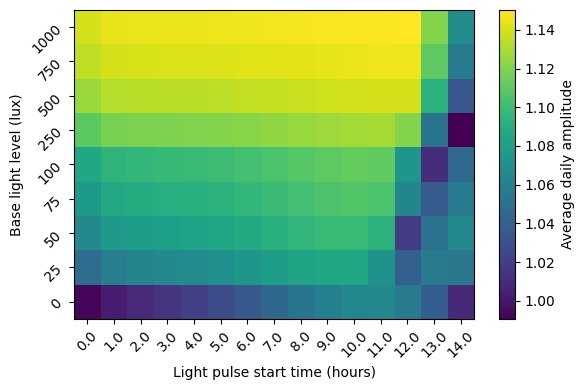

In [9]:
# Plot a heatmap of the average amplitude
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
im = ax.imshow(avg_amplitude, aspect='auto', origin='lower', cmap='viridis', interpolation='nearest')
# plt.colorbar(label='Average Amplitude', ax=ax)
# Add a colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Average daily amplitude')
# cbar.set_ticks(np.linspace(1.0, 1.15, 9))
ax.set_xlabel('Light pulse start time (hours)')
ax.set_ylabel('Base light level (lux)')


current_xticks = ax.get_xticks()
current_yticks = ax.get_yticks()

new_xticks = np.arange(len(pulse_at_values))

new_xtick_labels = np.array([f'{x:.1f}' for x in pulse_at_values], dtype=str)
ax.set_xticks(new_xticks)
ax.set_xticklabels(new_xtick_labels, rotation=45)

new_ytick_labels = np.array(['', 0, 25, 50, 75, 100, 250, 500, 750, 1000, ''], dtype=str)
ax.set_yticks(current_yticks)
ax.set_yticklabels(new_ytick_labels, rotation=45)
ax.set_ylim(-0.5, 8.5)

ax.grid(False)

plt.tight_layout()
plt.savefig('../figures/sup_fig_1_average_amplitude_heatmap.png', bbox_inches='tight', dpi=300)

plt.show()

## Parameter distribution

In [161]:
selected_parameters = pd.read_csv('../data/simulations/sleep_parameter_exploration/sleep_parameter_exploration_results.csv')
time = np.load('../data/light_schedules/time.npy')
data = np.load('../data/simulations/reference_parameters/regular_light_without_forced_wakeup_simulation.npz', allow_pickle=True)
sleep_duration_no_forced_wakeup, sleep_onset_no_forced_wakeup, _ = sleep_metrics(time, data["sleep"])
sleep_duration_no_forced_wakeup = np.mean(sleep_duration_no_forced_wakeup)
sleep_onset_no_forced_wakeup = np.mean(sleep_onset_no_forced_wakeup % 24)
dlmo_no_forced_wakeup = np.mean((calculate_cbtmin(time, data["trajectory_states"]) - 7 ) % 24)

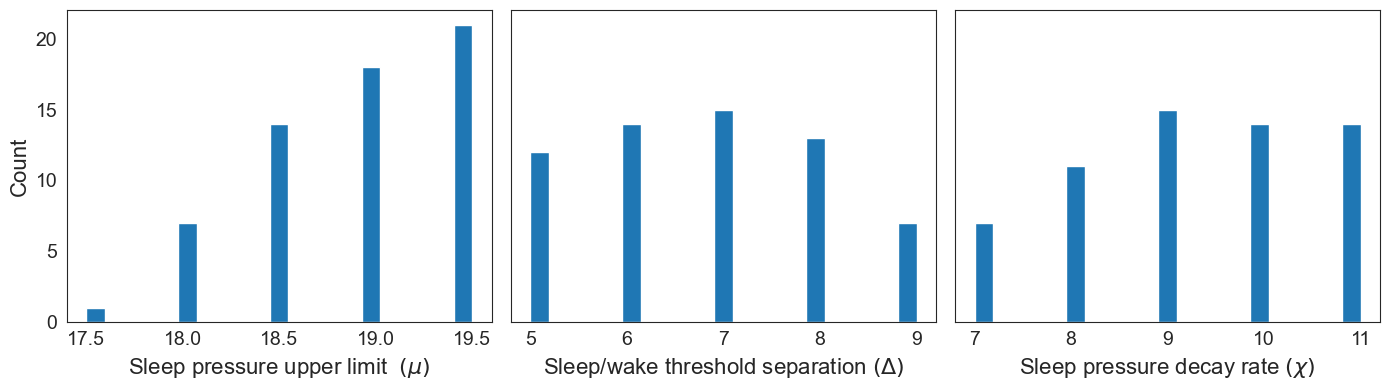

In [154]:
fig, axs = plt.subplots(1, 3, figsize=(1.75*figsize[0], figsize[1]), sharey=True)

axs[0].hist(selected_parameters['mu'], bins=21)
axs[0].set_xlabel('Sleep pressure upper limit  '+r'$(\mu)$', fontsize=axis_label_fontsize)
axs[0].set_ylabel('Count', fontsize=axis_label_fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

axs[1].hist(selected_parameters['Delta'], bins=21)
axs[1].set_xlabel('Sleep/wake threshold separation 'r'$(\Delta)$', fontsize=axis_label_fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

axs[2].hist(selected_parameters['chi'], bins=21)
axs[2].set_xlabel('Sleep pressure decay rate 'r'$(\chi)$', fontsize=axis_label_fontsize)
axs[2].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

plt.savefig('../figures/sup_fig_2_selected_sleep_parameters_histograms.png', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

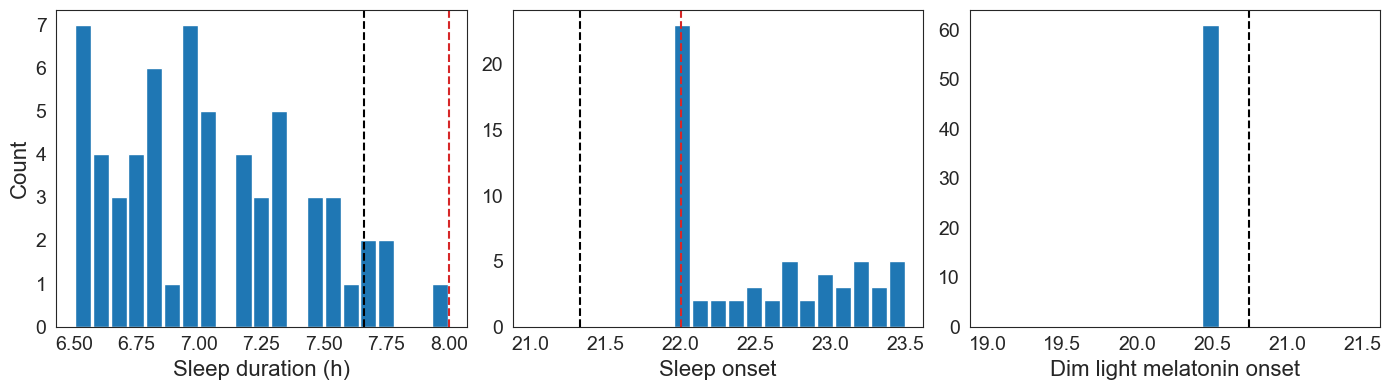

In [163]:
fig, axs = plt.subplots(1, 3, figsize=(1.75*figsize[0], figsize[1]))

axs[0].hist(selected_parameters['sleep_duration'], bins=21, rwidth=0.9, range=(6.5, 8))
axs[0].axvline(x=8.0, color='tab:red', linestyle='dashed')
axs[0].axvline(x=sleep_duration_no_forced_wakeup, color='black', linestyle='dashed')
axs[0].set_xlabel('Sleep duration (h)', fontsize=axis_label_fontsize)
axs[0].set_ylabel('Count', fontsize=axis_label_fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)


axs[1].hist(selected_parameters['sleep_onset'] % 24, bins=21, rwidth=0.9, range=(21.0, 23.5))
axs[1].axvline(x=sleep_onset_no_forced_wakeup, color='black', linestyle='dashed')
axs[1].axvline(x=22.0, color='tab:red', linestyle='dashed')
axs[1].set_xlabel('Sleep onset', fontsize=axis_label_fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

axs[2].hist(selected_parameters['dlmo'], bins=21, rwidth=0.9, range=(19, 21.5))
axs[2].axvline(x=dlmo_no_forced_wakeup, color='black', linestyle='dashed')
axs[2].set_xlabel('Dim light melatonin onset', fontsize=axis_label_fontsize)
axs[2].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

plt.savefig('../figures/sup_fig_2_selected_sleep_parameters_metrics_histograms.png', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

In [164]:
selected_parameters_circadian = pd.read_csv('../data/simulations/circadian_parameter_exploration/circadian_parameter_exploration_results.csv')

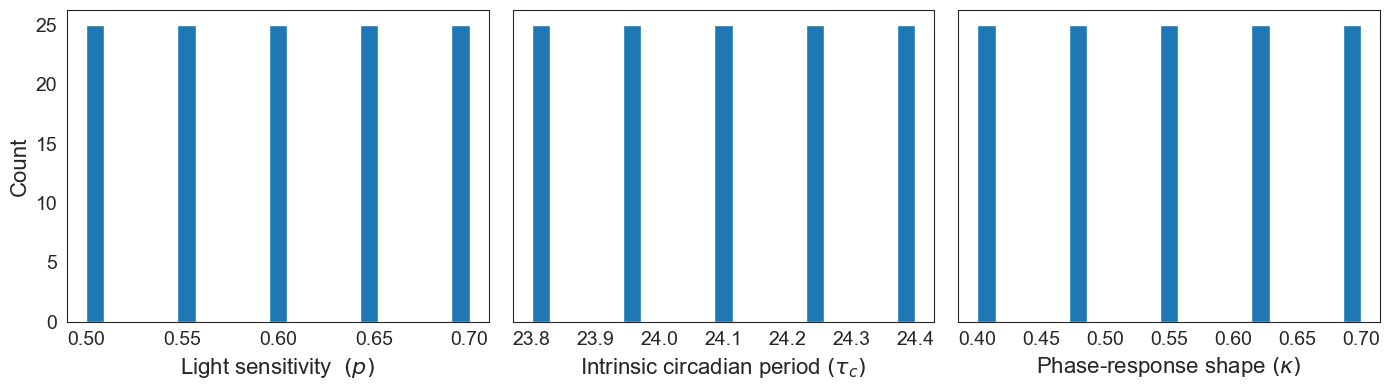

In [165]:
fig, axs = plt.subplots(1, 3, figsize=(1.75*figsize[0], figsize[1]), sharey=True)

axs[0].hist(selected_parameters_circadian['p'], bins=21)
axs[0].set_xlabel('Light sensitivity  '+r'$(p)$', fontsize=axis_label_fontsize)
axs[0].set_ylabel('Count', fontsize=axis_label_fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

axs[1].hist(selected_parameters_circadian['tauc'], bins=21)
axs[1].set_xlabel('Intrinsic circadian period 'r'$(\tau_{c})$', fontsize=axis_label_fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

axs[2].hist(selected_parameters_circadian['k'], bins=21)
axs[2].set_xlabel('Phase-response shape 'r'$(\kappa)$', fontsize=axis_label_fontsize)
axs[2].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

plt.savefig('../figures/sup_fig_2_selected_circadian_parameters_histograms.png', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

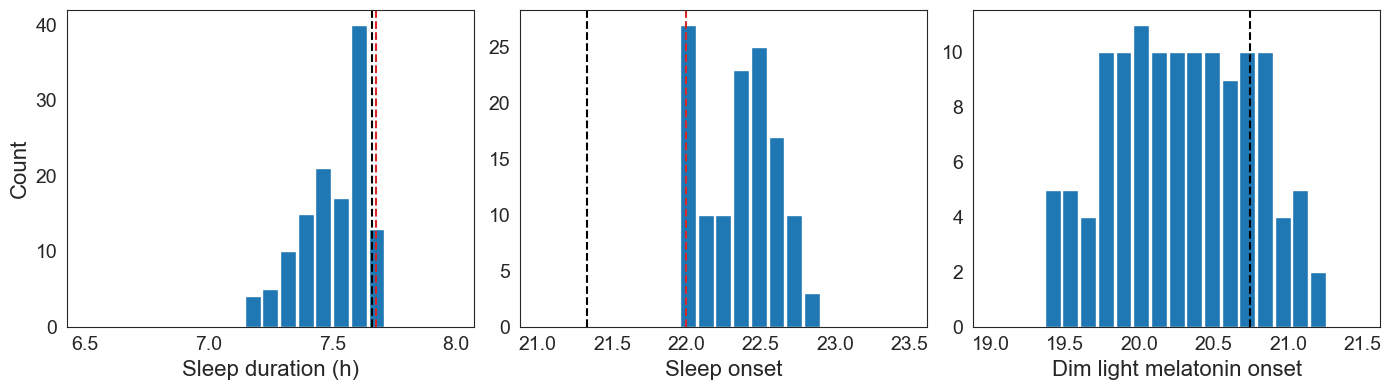

In [167]:
fig, axs = plt.subplots(1, 3, figsize=(1.75*figsize[0], figsize[1]))

axs[0].hist(selected_parameters_circadian['sleep_duration'], bins=21, rwidth=0.9, range=(6.5, 8))
axs[0].axvline(x=np.max(selected_parameters_circadian['sleep_duration']), color='tab:red', linestyle='dashed')
axs[0].axvline(x=sleep_duration_no_forced_wakeup, color='black', linestyle='dashed')
axs[0].set_xlabel('Sleep duration (h)', fontsize=axis_label_fontsize)
axs[0].set_ylabel('Count', fontsize=axis_label_fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

axs[1].hist(selected_parameters_circadian['sleep_onset'] % 24, bins=21, rwidth=0.9, range=(21.0, 23.5))
axs[1].axvline(x=sleep_onset_no_forced_wakeup, color='black', linestyle='dashed')
axs[1].axvline(x=22.0, color='tab:red', linestyle='dashed')
axs[1].set_xlabel('Sleep onset', fontsize=axis_label_fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

axs[2].hist(selected_parameters_circadian['dlmo'], bins=21, rwidth=0.9, range=(19, 21.5))
axs[2].axvline(x=dlmo_no_forced_wakeup, color='black', linestyle='dashed')
axs[2].set_xlabel('Dim light melatonin onset', fontsize=axis_label_fontsize)
axs[2].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

plt.savefig('../figures/sup_fig_2_selected_circadian_parameters_metrics_histograms.png', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()


## Metrics evolution for circadian parameter exploration

In [207]:
def truncate_colormap(cmap, minval=0.25, maxval=1.0, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

In [208]:
selected_parameters = pd.read_csv('../data/simulations/circadian_parameter_exploration/circadian_parameter_exploration_results.csv', index_col=0)
simulation_features = pd.read_csv("../data/simulations/chang14_circadian_parameters/chang14_circadian_parameters_features.csv", index_col=0)

baseline_lux_options = [90, 500]

### CBTmin

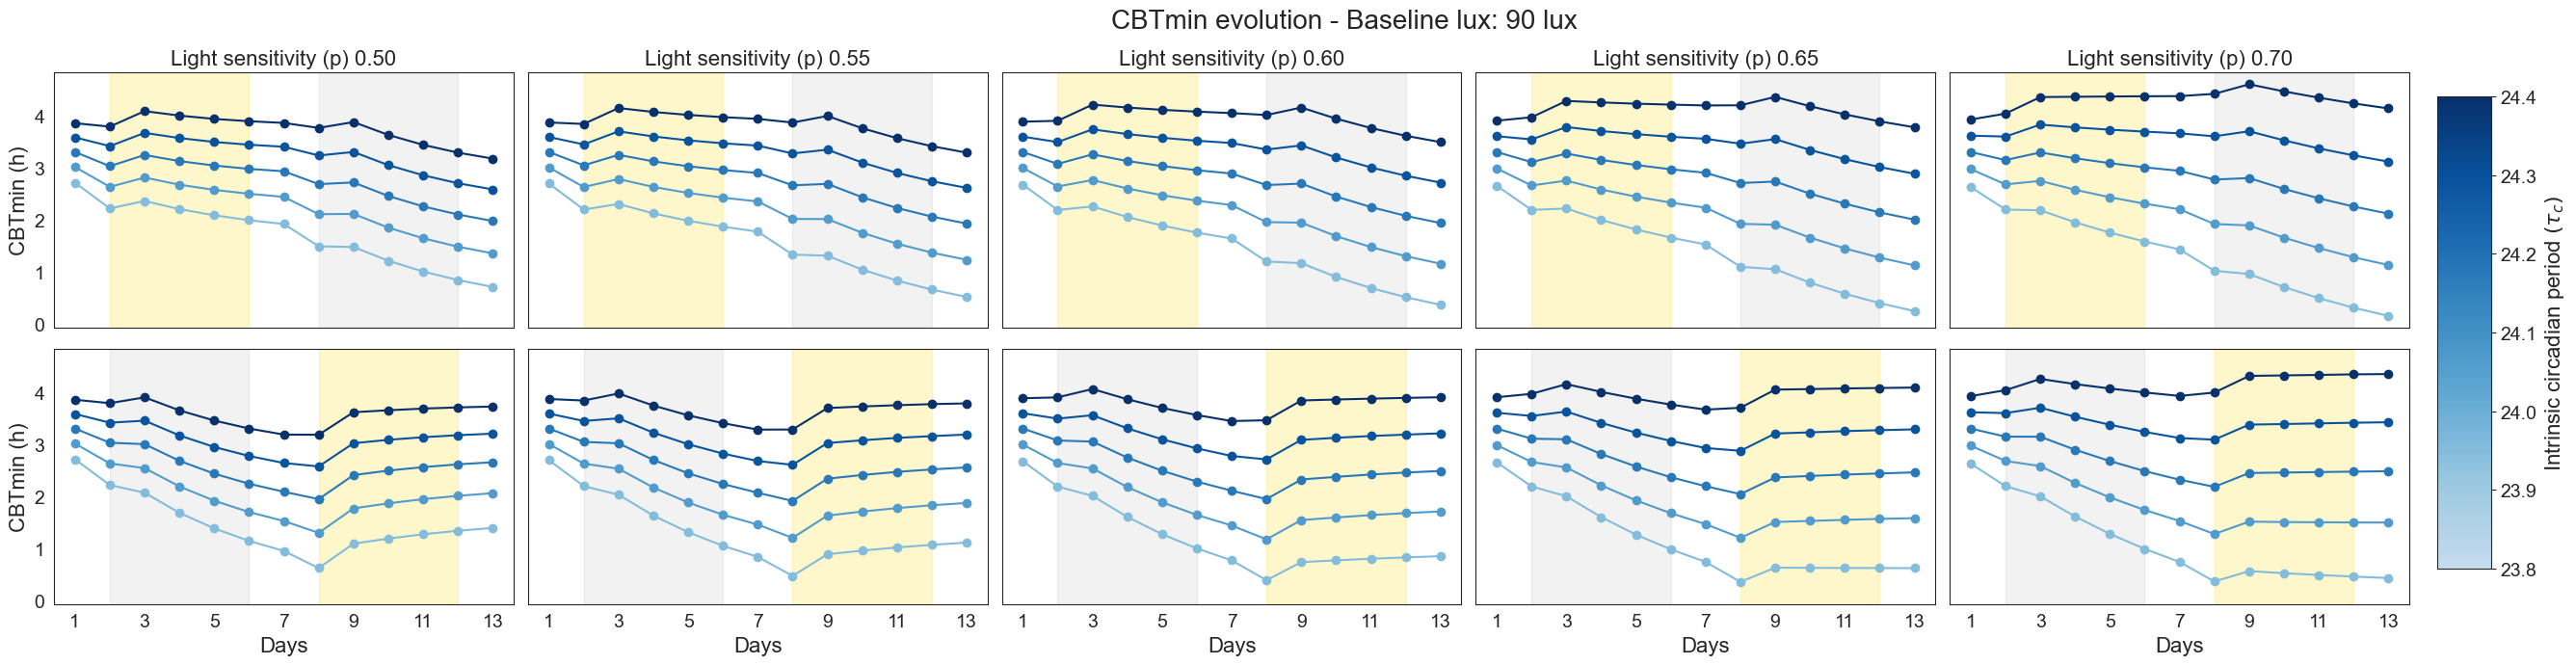

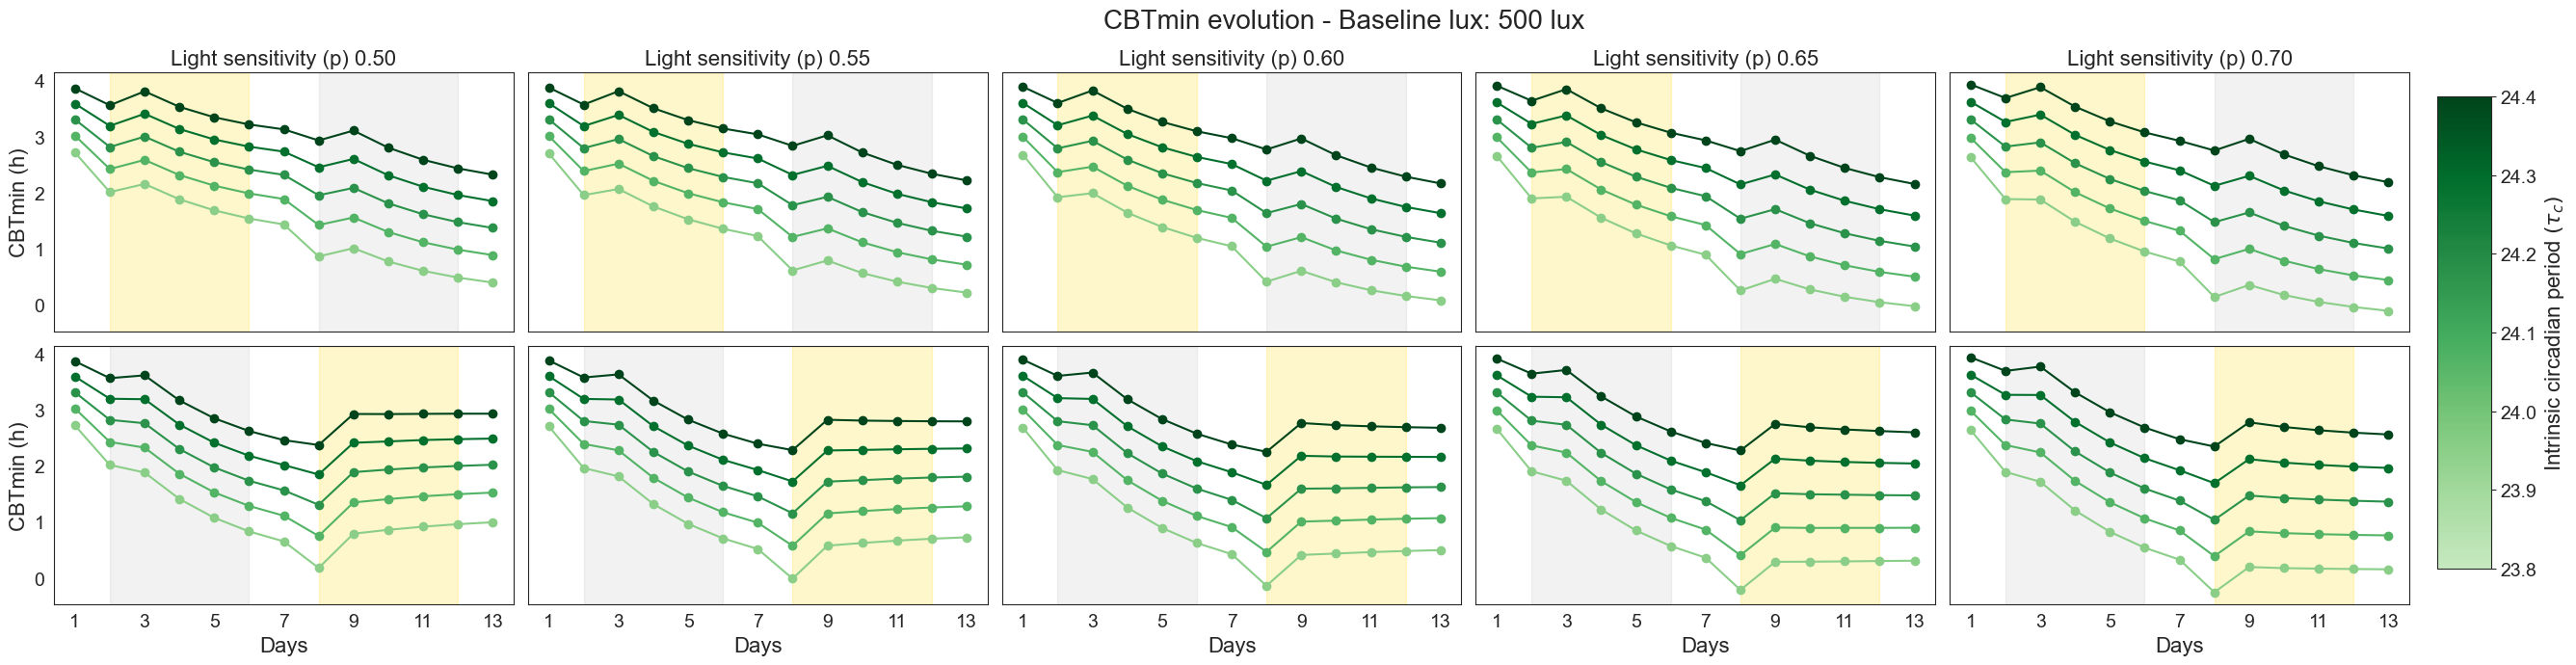

In [210]:
figsize_scaling = 0.875
p_values = np.linspace(0.5, 0.7, 5)
tauc_values = np.linspace(23.8, 24.4, 5)
base_color_maps = [plt.get_cmap('Blues'), plt.get_cmap('Greens')]
color_maps = [truncate_colormap(cmap, minval=0.25, maxval=1) for cmap in base_color_maps]
color_map_values = [color_maps[0](np.linspace(0.25, 1, len(p_values))),
                    color_maps[1](np.linspace(0.25, 1, len(p_values)))]

ebook_order_options = ['ebook_first', 'ebook_second']

for idx, baseline_lux in enumerate(baseline_lux_options):
    fig, axs = plt.subplots(2, len(p_values), figsize=(figsize_scaling * figsize[0] * 4, figsize_scaling * figsize[1] * 2), 
                            sharey=True, sharex=True)
    figure_title = f"CBTmin evolution - Baseline lux: {baseline_lux} lux"
    fig.suptitle(figure_title, fontsize=title_fontsize)
    axs[0, 0].set_ylabel('CBTmin (h)', fontsize=axis_label_fontsize)
    axs[1, 0].set_ylabel('CBTmin (h)', fontsize=axis_label_fontsize)

    for jdx, ebook_order in enumerate(ebook_order_options):
        for kdx, p_val in enumerate(p_values):
            axs[0, kdx].set_title(f"Light sensitivity (p) {p_val:.2f}", fontsize=axis_label_fontsize)
            axs[0, kdx].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
            axs[1, kdx].set_xlabel('Days', fontsize=axis_label_fontsize)
            axs[1, kdx].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

            simulation_condition = f"{ebook_order}"
            relevant_features = simulation_features[(simulation_features['baseline_lux'] == baseline_lux) &
                                                    (simulation_features['simulation_condition'] == simulation_condition)
                                                    ]
            merged_features = pd.merge(selected_parameters[['p', 'tauc']], relevant_features, on='simulation_idx') 
            final_features = merged_features[merged_features['p'] == p_val]
            unique_tauc = final_features['tauc'].unique()

            for tauc in unique_tauc:
                sim_data = final_features[final_features['tauc'] == tauc]
                cbtmin = sim_data.groupby('day')['cbtmin'].mean()
                days = np.arange(1, len(cbtmin) + 1)
                color = color_map_values[idx][np.where(tauc_values == tauc)[0][0]]
                axs[jdx, kdx].plot(days, cbtmin, marker='o', color=color)
                axs[jdx, kdx].set_xticks(days[::2])
                
            if jdx == 0:
                axs[jdx, kdx].axvspan(2, 6, color='gold', alpha=0.2) # eBook
                axs[jdx, kdx].axvspan(8, 12, color='gray', alpha=0.1) # Book
            else:
                axs[jdx, kdx].axvspan(2, 6, color='gray', alpha=0.1)
                axs[jdx, kdx].axvspan(8, 12, color='gold', alpha=0.2)

    # make room for cbar on the right
    plt.tight_layout(rect=[0, 0, 0.9, 1.0])
    # add colorbar
    cbar_ax = fig.add_axes([0.905, 0.15, 0.02, 0.7])
    norm = Normalize(vmin=min(tauc_values), vmax=max(tauc_values))
    sm = ScalarMappable(cmap=color_maps[idx], norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Intrinsic circadian period 'r'$(\tau_{c})$', fontsize=axis_label_fontsize)
    cbar.ax.tick_params(labelsize=tick_label_fontsize)

    plt.savefig(f'../figures/sup_fig_3_{baseline_lux}_indoor_light_cbtmin_evolution.png', bbox_inches='tight', dpi=300)

    plt.show()
    plt.close(fig)

### Sleep onset

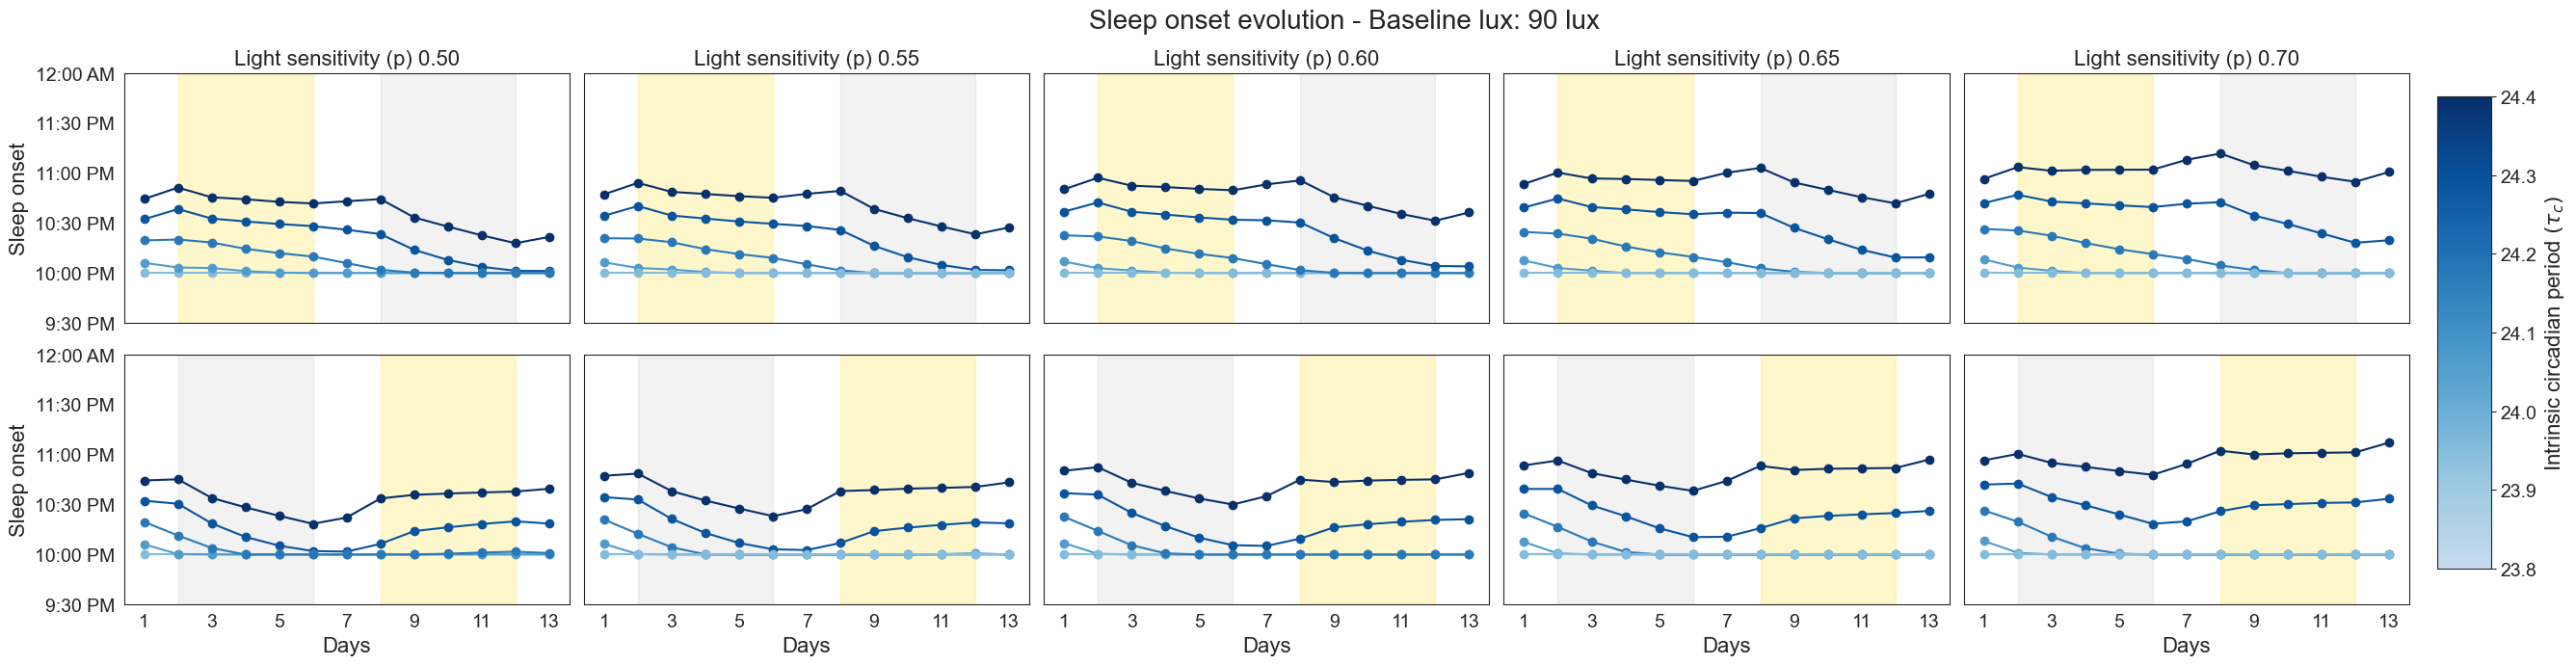

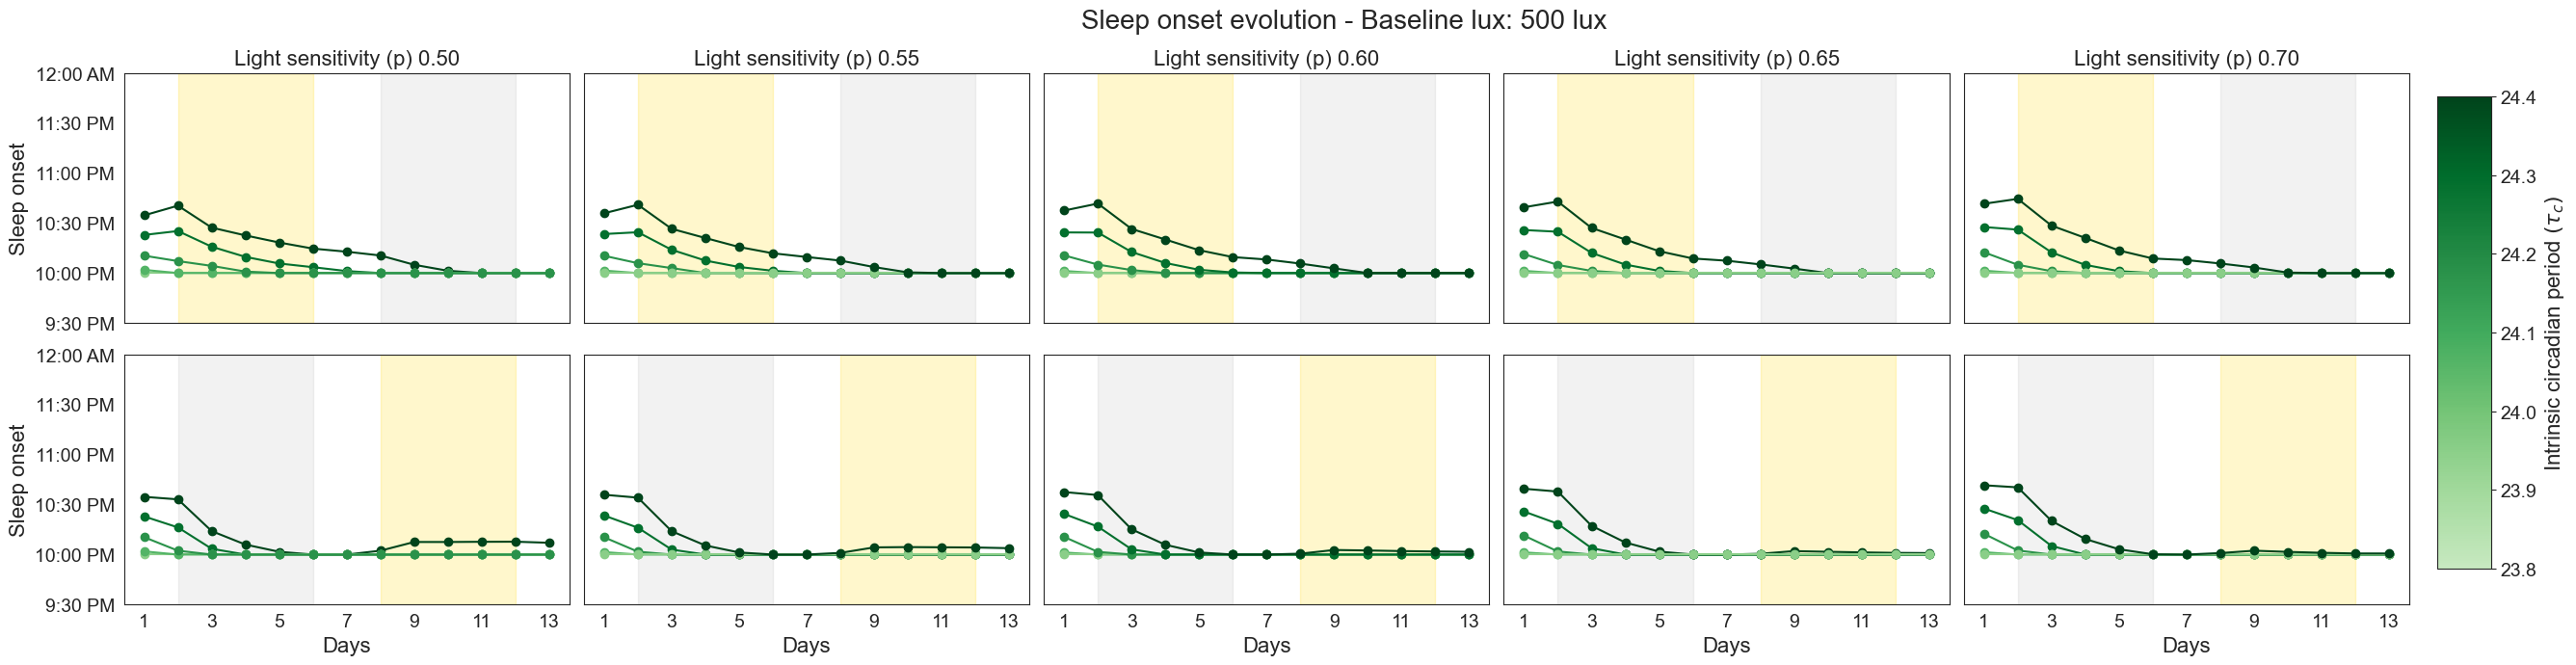

In [ ]:
figsize_scaling = 0.875
p_values = np.linspace(0.5, 0.7, 5)
tauc_values = np.linspace(23.8, 24.4, 5)
base_color_maps = [plt.get_cmap('Blues'), plt.get_cmap('Greens')]
color_maps = [truncate_colormap(cmap, minval=0.25, maxval=1) for cmap in base_color_maps]
color_map_values = [color_maps[0](np.linspace(0.25, 1, len(p_values))),
                    color_maps[1](np.linspace(0.25, 1, len(p_values)))]

ebook_order_options = ['ebook_first', 'ebook_second']

for idx, baseline_lux in enumerate(baseline_lux_options):
    fig, axs = plt.subplots(2, len(p_values), figsize=(figsize_scaling * figsize[0] * 4, figsize_scaling * figsize[1] * 2), 
                            sharey=True, sharex=True)
    figure_title = f"Sleep onset evolution - Baseline lux: {baseline_lux} lux"
    fig.suptitle(figure_title, fontsize=title_fontsize)
    axs[0, 0].set_ylabel('Sleep onset', fontsize=axis_label_fontsize)
    axs[1, 0].set_ylabel('Sleep onset', fontsize=axis_label_fontsize)

    for jdx, ebook_order in enumerate(ebook_order_options):
        for kdx, p_val in enumerate(p_values):
            axs[0, kdx].set_title(f"Light sensitivity (p) {p_val:.2f}", fontsize=axis_label_fontsize)
            axs[0, kdx].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
            axs[1, kdx].set_xlabel('Days', fontsize=axis_label_fontsize)
            axs[1, kdx].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

            simulation_condition = f"{ebook_order}"
            relevant_features = simulation_features[(simulation_features['baseline_lux'] == baseline_lux) &
                                                    (simulation_features['simulation_condition'] == simulation_condition)
                                                    ]
            merged_features = pd.merge(selected_parameters[['p', 'tauc']], relevant_features, on='simulation_idx') 
            final_features = merged_features[merged_features['p'] == p_val]
            unique_tauc = final_features['tauc'].unique()


            for tauc in unique_tauc:
                sim_data = final_features[final_features['tauc'] == tauc]
                sleep_onset = sim_data.groupby('day')['sleep_onset'].mean()
                days = np.arange(1, len(sleep_onset) + 1)
                color = color_map_values[idx][np.where(tauc_values == tauc)[0][0]]
                axs[jdx, kdx].plot(days, sleep_onset, marker='o', color=color)
                axs[jdx, kdx].set_xticks(days[::2])
                axs[jdx, kdx].set_xticks(days[::2])
                axs[jdx, kdx].set_yticks([21.5, 22, 22.5, 23, 23.5, 24])
                axs[jdx, kdx].set_yticklabels(['9:30 PM', '10:00 PM', '10:30 PM', '11:00 PM', '11:30 PM', '12:00 AM'],
                                            fontsize=tick_label_fontsize)

            if jdx == 0:
                axs[jdx, kdx].axvspan(2, 6, color='gold', alpha=0.2) # eBook
                axs[jdx, kdx].axvspan(8, 12, color='gray', alpha=0.1) # Book
            else:
                axs[jdx, kdx].axvspan(2, 6, color='gray', alpha=0.1)
                axs[jdx, kdx].axvspan(8, 12, color='gold', alpha=0.2)

    # make room for cbar on the right
    plt.tight_layout(rect=[0, 0, 0.9, 1.0])
    # add colorbar
    cbar_ax = fig.add_axes([0.905, 0.15, 0.02, 0.7])
    norm = Normalize(vmin=min(tauc_values), vmax=max(tauc_values))
    sm = ScalarMappable(cmap=color_maps[idx], norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Intrinsic circadian period 'r'$(\tau_{c})$', fontsize=axis_label_fontsize)
    cbar.ax.tick_params(labelsize=tick_label_fontsize)

    plt.savefig(f'../figures/sup_fig_3_{baseline_lux}_indoor_light_sleep_onset_evolution.png', bbox_inches='tight', dpi=300)

    plt.show()
    plt.close(fig)

## Light sensitivity curves

In [168]:
def sensitivity(light, p, alpha_0=0.16, I0=9500.0):
    return alpha_0 * (light / I0) ** p

sensitivity = np.vectorize(sensitivity)

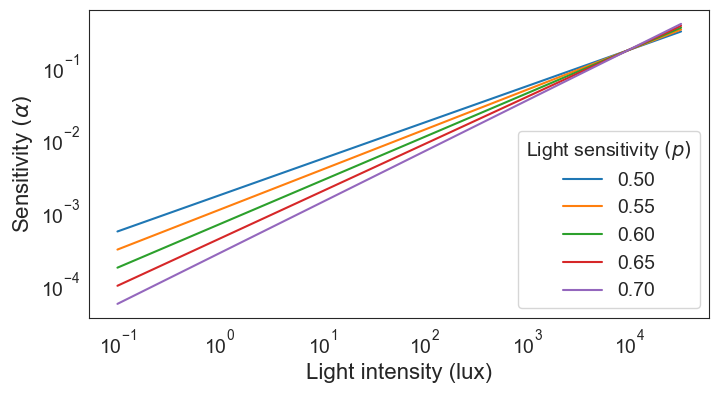

In [169]:
p_values = np.array([0.5, 0.55, 0.6, 0.65, 0.7])
light = np.logspace(-1, 4.5, 1000)

fig, ax = plt.subplots(figsize=figsize)
ax.set_xscale('log')
for p in p_values:
    ax.plot(light, sensitivity(light, p), label=f"{p:.2f}")

ax.set_yscale('log')
ax.set_xlabel('Light intensity (lux)', fontsize=axis_label_fontsize)
ax.set_ylabel('Sensitivity 'r'$(\alpha)$', fontsize=axis_label_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

plt.legend(title='Light sensitivity 'r'$(p)$', fontsize=legend_fontsize, title_fontsize=legend_fontsize)
plt.savefig('../figures/sup_fig_4_light_sensitivity.png', bbox_inches='tight', dpi=300)
plt.show()

## Detailed phase shift results

In [69]:
figsize_scaling = 0.85
selected_parameters = pd.read_csv(f'../data/simulations/circadian_parameter_exploration/circadian_parameter_exploration_results.csv', index_col=0)
simulation_features = pd.read_csv("../data/simulations/chang14_circadian_parameters/chang14_circadian_parameters_features.csv", index_col=0)

In [70]:
def get_shift_data(simulation_features, baseline_lux, ebook_order):
    book_day = 12 if ebook_order == 'ebook_first' else 6
    ebook_day = 6 if ebook_order == 'ebook_first' else 12
    book_cbtmin = simulation_features[(simulation_features['day'] == book_day) & (simulation_features['daily_condition'] == 'Book') &
                                        (simulation_features['simulation_condition'] == f'{ebook_order}') &
                                        (simulation_features['baseline_lux'] == baseline_lux)]
    ebook_cbtmin = simulation_features[(simulation_features['day'] == ebook_day) & (simulation_features['daily_condition'] == 'eBook') &
                                        (simulation_features['simulation_condition'] == f'{ebook_order}') &
                                        (simulation_features['baseline_lux'] == baseline_lux)]

    shift = pd.DataFrame()
    shift['diff'] = ebook_cbtmin['cbtmin'] - book_cbtmin['cbtmin']
    shift['simulation_condition'] = ebook_cbtmin['simulation_condition']
    shift['baseline_lux'] = baseline_lux
    shift['p'] = selected_parameters['p'].values
    shift['k'] = selected_parameters['k'].values
    shift['tauc'] = selected_parameters['tauc'].values

    return shift

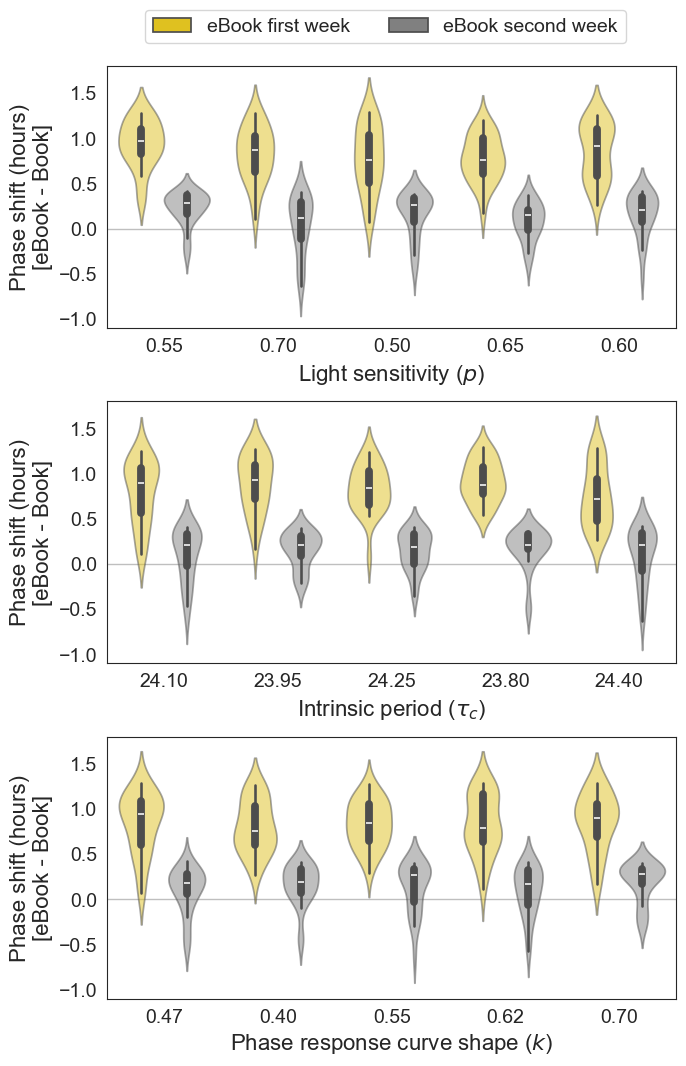

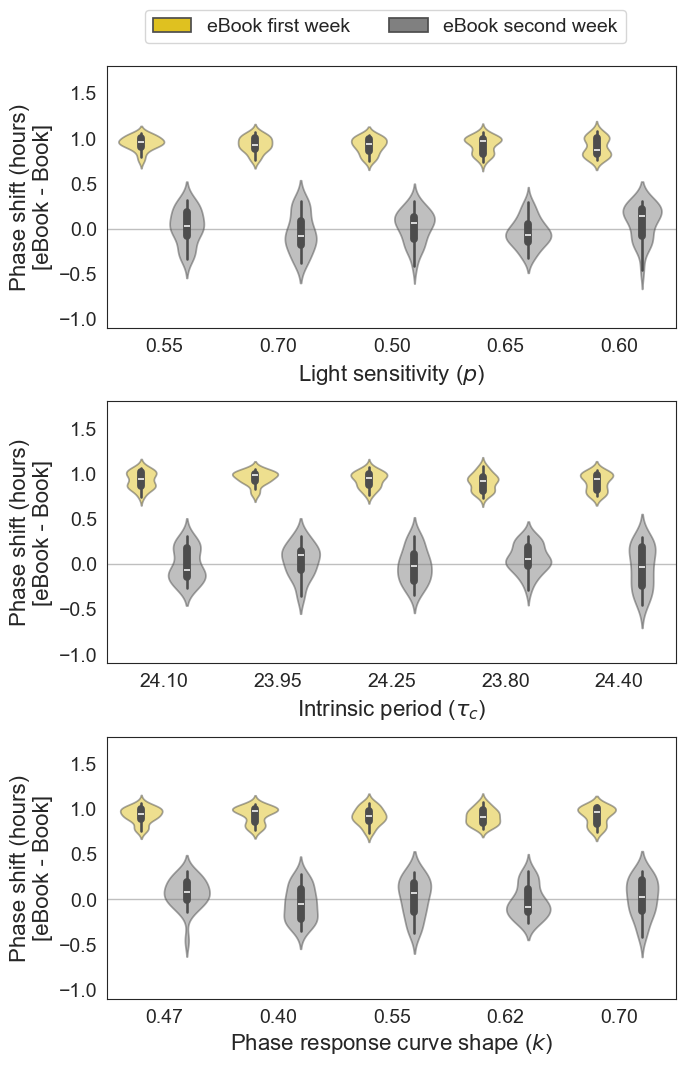

In [71]:
show_fig = True
baseline_lux_options = [90, 500]

for baseline_lux in baseline_lux_options:
    shift_first = get_shift_data(simulation_features, baseline_lux, 'ebook_first')
    shift_second = get_shift_data(simulation_features, baseline_lux, 'ebook_second')
    df = pd.concat([shift_first, shift_second])

    sns.set_style('white')

    palette = {
        'ebook_first': 'gold',
        'ebook_second': 'gray'
    }

    fig, ax = plt.subplots(3, 1, figsize=(figsize_scaling * figsize[0], figsize_scaling * figsize[1]*3), sharey=True)
    sns.violinplot(x='p', y='diff', hue='simulation_condition', data=df, ax=ax[0], palette=palette,)
    sns.violinplot(x='tauc', y='diff', hue='simulation_condition', data=df, ax=ax[1], legend=False, palette=palette)
    sns.violinplot(x='k', y='diff', hue='simulation_condition', data=df, ax=ax[2], legend=False, palette=palette)

    for ax_i in ax:
        for violin  in ax_i.collections[::]:
            violin.set_alpha(0.5)

    # adjust legend position
    handles, labels = ax[0].get_legend_handles_labels()
    labels = ['eBook first week', 'eBook second week']
    fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.55, 1.05), loc='upper center', fontsize=legend_fontsize)

    ax[0].get_legend().remove()
    ax[0].set_xticks(range(len(df['p'].unique())))
    ax[0].set_xticklabels([f'{p:.2f}' for p in df['p'].unique()], fontsize=tick_label_fontsize)
    ax[1].set_xticks(range(len(df['tauc'].unique())))
    ax[1].set_xticklabels([f'{p:.2f}' for p in df['tauc'].unique()], fontsize=tick_label_fontsize)
    ax[2].set_xticks(range(len(df['k'].unique())))
    ax[2].set_xticklabels([f'{p:.2f}' for p in df['k'].unique()], fontsize=tick_label_fontsize)

    ax[0].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
    ax[1].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
    ax[2].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    ax[0].set_ylabel('Phase shift (hours)\n[eBook - Book]', fontsize=axis_label_fontsize)
    ax[1].set_ylabel('Phase shift (hours)\n[eBook - Book]', fontsize=axis_label_fontsize)
    ax[2].set_ylabel('Phase shift (hours)\n[eBook - Book]', fontsize=axis_label_fontsize)
    ax[0].set_xlabel(r'Light sensitivity ($p$)', fontsize=axis_label_fontsize)
    ax[1].set_xlabel(r'Intrinsic period ($\tau_{c}$)', fontsize=axis_label_fontsize)
    ax[2].set_xlabel(r'Phase response curve shape ($k$)', fontsize=axis_label_fontsize)

    ax[0].set_ylim(-1.1, 1.8)
    ax[1].set_ylim(-1.1, 1.8)
    ax[2].set_ylim(-1.1, 1.8)

    ax[0].axhline(0, color='black', linewidth=1, linestyle='-', zorder=0, alpha=0.25)
    ax[1].axhline(0, color='black', linewidth=1, linestyle='-', zorder=0, alpha=0.25)
    ax[2].axhline(0, color='black', linewidth=1, linestyle='-', zorder=0, alpha=0.25)

    plt.tight_layout()

    plt.savefig(f"../figures/sup_fig_5_phase_shift_indoor_lux_{baseline_lux}.png", bbox_inches='tight', dpi=300)

    if show_fig:
        plt.show()